# Outline

This notebook contains code for testing/profiling the usage of multi-output CNNs and RNNs for predicting the genomic locations of TSSes in the E. coli K-12 MG1655 genome given the region upstream of a gene

# Import Packages

In [1]:
# built-in
from pathlib import Path
import sys
from timeit import time

# third-party (install required)
from Bio.motifs import Motif
from Bio.SeqUtils import GC
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import KFold
from sklearn.utils import compute_class_weight
from tensorflow import keras
from tqdm.notebook import tqdm

# local modules
sys.path.append('../../bitome2')

from bitome.core import Bitome
from bitome.util import create_motif, score_motif_match

# define paths
K12_DATA_PATH = Path('../data/bitome2/mg1655')

# Construct K-12 MG1655 Bitome

In [2]:
# from GenBank annotation
origin = (3925743, 3925975)
# from 1. Duggin, I. G. & Bell, S. D. J. Mol. Biol. (2009). with the following terA/terC sequences:
# ter_a = 'AATTAGTATGTTGTAACTAAAGT'
# ter_c = 'ATATAGGATGTTGTAACTAATAT'
terminus = (1341745, 1609180)
cid_boundaries = [50000, 142779, 223485, 446815, 927474, 985894, 1080000, 1195008, 1301085, 1577657,
                 1799393, 1852621, 2102875, 2259719, 2380722, 2533498, 2726069, 2905711, 2996372, 3297098,
                 3423423, 3440040, 3652182, 3811250, 3941516, 4035239, 4166484, 4470986]

In [3]:
mg1655 = Bitome(
    Path(K12_DATA_PATH, 'NC_000913.3.gb'),
    name='MG1655',
    origin=origin, terminus=terminus,
    cid_boundaries=cid_boundaries,
    gene_table=Path(K12_DATA_PATH, 'gene_info_supp.csv'),
    tu_table=Path(K12_DATA_PATH, 'tu.csv'),
    operon_table=Path(K12_DATA_PATH, 'operon.csv'),
    tss_table=Path(K12_DATA_PATH, 'tss.csv'),
    tfbs_table=Path(K12_DATA_PATH, 'tfbs.csv'),
    terminator_table=Path(K12_DATA_PATH, 'terminator.csv'),
    attenuator_table=Path(K12_DATA_PATH, 'attenuator.csv'),
    rbs_table=Path(K12_DATA_PATH, 'rbs.csv'),
    riboswitch_table=Path(K12_DATA_PATH, 'riboswitch.csv')
)

# Motif-Based (non-ML) Baseline

## Create Crude Promoter Motifs

In [675]:
tu_table_with_boxes = mg1655.tu_table.dropna(subset=['tss', 'sigma_factor', 'box_10_left', 'box_35_left'])


sigma_prom_seq_dict = {}

for tu_with_box_row in tu_table_with_boxes.itertuples():
    # extract the range from the edges of the boxes
    if tu_with_box_row.strand == 1:
        motif_range_l, motif_range_r = tu_with_box_row.box_35_left, tu_with_box_row.tss
    else:
        motif_range_l, motif_range_r = tu_with_box_row.tss, tu_with_box_row.box_35_right
    motif_range_seq = mg1655.get_sequence(motif_range_l, motif_range_r, tu_with_box_row.strand)
    
    sig_raw = tu_with_box_row.sigma_factor
    sigs = [s.strip() for s in sig_raw.split(',')]
    for sig in sigs:
        if sig in sigma_prom_seq_dict:
            sigma_prom_seq_dict[sig].append(motif_range_seq)
        else:
            sigma_prom_seq_dict[sig] = [motif_range_seq]
            
# make a motif for each 
sig_prom_motif_dict = {}

for sig, sig_seqs in sigma_prom_seq_dict.items():
    sig_prom_motif_dict[sig] = create_motif(sig_seqs)

## Motif Score Promoters

In [690]:
sandbox_prom_range_seq_df.head()

,gene,left,right,strand,seq,tsses,tus
0,b0008,7988,8263,1.0,GCTTCCCTCCAGTTAAACAGGCAGTACTATCATAAAGAGAAATTTG...,[8191.0],[ECK120015352]
1,b0014,11913,12188,1.0,TCCAGCTATGGTTAATAAAATGGGTAGATTTGCAGAGGTGATATAT...,"[12048.0, 12123.0, 12144.0]","[ECK120009450, ECK120009602, ECK120009603]"
2,b0019,17239,17514,1.0,GATTTCTTAGCTACGTCTACAAAGTGAAAAATAAAGAGAAAGTCCA...,"[17317.0, 17458.0]","[ECK120009006, ECK120009391]"
3,b0023,21053,21328,-1.0,AAGAATCGACTAAACTATAATCGGTTCCAGGTTGAGGGTTTACACA...,"[21210.0, 21120.0]","[ECK120015339, ECK120015340]"
4,b0025,21157,21432,1.0,AATACATACGGCGCATAGTCGAAGTACAGACCGAGTTTTGTCACTT...,[21383.0],[ECK120009479]


In [737]:
tss_prob_ranks = []

for prom_range_row in tqdm(sandbox_prom_range_seq_df.itertuples()):
    
    # we flipped the sequence when making it; flip back
    search_sequence = prom_range_row.seq[::-1]
    
    # score each sigma's promoter motif at each position
    sig_score_dict = {}
    for sig, sig_motif in sig_prom_motif_dict.items():
        
        sig_scores_by_tss_idx = {}
        for i in range(len(search_sequence) - len(sig_motif) + 1):
            sub_sequence = search_sequence[i:i+len(sig_motif)]
            # because the downstream (right) side is where the TSS is
            sig_scores_by_tss_idx[i+len(sig_motif) - 1] = score_motif_match(sub_sequence, sig_motif.pssm)
        sig_score_dict[sig] = sig_scores_by_tss_idx
            
    i_max_score_dict = {}

    for i in range(len(search_sequence)):
        i_max_score = -np.inf
        for sig, sig_scores in sig_score_dict.items():
            if i in sig_scores and sig_scores[i] > i_max_score:
                i_max_score = sig_scores[i]
        i_max_score_dict[i] = i_max_score
        
    sorted_i, _ = list(zip(*sorted(i_max_score_dict.items(), key=lambda tup: tup[1], reverse=True)))
            
    # get the true tss idxes and their rank
    pos_range = np.arange(prom_range_row.left, prom_range_row.right + 1)
    if prom_range_row.strand == -1:
        pos_range = np.flip(pos_range)

    for tss in prom_range_row.tsses:
        tss_idx = np.argwhere(pos_range == tss)
        # hacky because we might miss the TSS
        if len(tss_idx) > 0:
            tss_idx = tss_idx[0][0]
            tss_prob_rank = np.argwhere(np.array(sorted_i) == tss_idx)
            if len(tss_prob_rank) > 0:
                tss_prob_ranks.append(tss_prob_rank[0][0])

In [ ]:
# re-do this as a 5-fold 

No handles with labels found to put in legend.


Text(0, 0.5, '# of TSS')

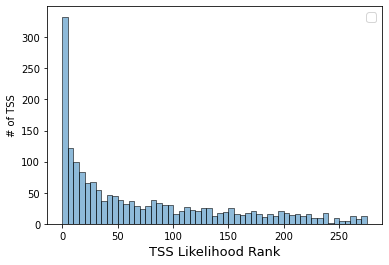

In [738]:
_, ax = plt.subplots()
        
sns.histplot(tss_prob_ranks, binwidth=5, alpha=0.5, ax=ax)
ax.legend(fontsize=12)
ax.set_xlabel('TSS Likelihood Rank', fontsize=13)
ax.set_ylabel('# of TSS')

# Load 5-mer Shape and Sigma Motifs

In [4]:
fivemer_shape_df = pd.read_csv('../data/5mer_shape_lookup.csv', index_col=0)

In [5]:
fivemer_shape_df

,Opening,Rise,Stretch,EP,Tilt,Shear,ProT,Buckle,Shift,HelT,Stagger,Slide,MGW,Roll
AAAAA,-3.71,3.250,0.03,-10.10,-0.970,0.18,-16.51,7.80,-0.140,37.875,-0.22,-0.980,3.38,-5.070
AAAAC,-1.90,3.200,-0.01,-8.97,-1.405,0.15,-14.47,9.07,0.010,37.040,-0.06,-1.060,4.05,-4.210
AAAAG,-2.30,3.235,0.01,-10.39,-1.475,0.17,-14.68,7.39,0.045,37.100,-0.13,-1.140,3.68,-5.350
AAAAT,-2.05,3.275,-0.01,-10.80,-1.280,0.17,-14.89,7.97,0.030,37.305,-0.10,-1.150,3.63,-4.340
AAACA,-1.30,3.280,-0.01,-8.05,-0.960,0.15,-13.05,11.53,0.250,35.905,0.13,-1.300,4.65,-2.935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGT,-1.70,3.300,-0.03,-7.86,-0.225,-0.09,-12.03,-2.71,0.315,35.590,-0.25,-1.095,5.21,1.765
TTTTA,-2.26,3.175,-0.02,-8.39,0.855,-0.15,-13.29,-7.24,0.180,36.160,-0.11,-1.050,4.89,-2.605
TTTTC,-2.28,3.200,-0.01,-9.65,1.080,-0.16,-13.16,-6.00,0.210,36.660,-0.16,-1.035,4.35,-3.995
TTTTG,-2.39,3.190,-0.03,-8.76,1.270,-0.15,-13.79,-7.51,0.120,36.215,-0.11,-1.040,4.76,-2.475


In [131]:
sigma_motifs = mg1655.create_sigma_motifs()

# Create RNN Dataset [Functions]

Our samples will be the stretches of DNA upstream of a known gene start; we want a parameter to control the exact distance upstream (and downstream, optionally) from the gene start to create a promoter "window" in which we will look for TSSes

Start from known transcription units with known TSS

Also want to compute motif scores and shape; add helpers for that

## Get Motif Scores

In [132]:
def get_motif_scores(seq):
    """
    Given a sequence, compute all sigma factor binding motif scores available
    """
    
    # instantiate a data structure to hold the motif scores for all sigma factors
    motif_score_dict = {}
    for sigma, sigma_motif_dict in sigma_motifs.items():
        for motif_suffix, motif_obj in sigma_motif_dict.items():
            # only want to work with -10 and -35
            if '-10' in motif_suffix or '-35' in motif_suffix:
                scores = motif_obj.pssm.calculate(seq)
                # we want the score to correspond to the MIDDLE of the subseq that was scored
                # we will treat the "middle" of even-length motifs as the rightmost of the 2 middle bps
                # first_i is ALSO equal to pad length on the left
                # special case; if motif is even, due to our above choice, pad on the right is 1 less
                first_i = len(motif_obj) // 2
                left_pad = first_i
                if len(motif_obj) % 2 == 0:
                    right_pad = first_i - 1
                else:
                    right_pad = first_i
                padded_scores = np.pad(scores, (left_pad, right_pad), mode='minimum')
                motif_score_dict[f'{sigma}_{motif_suffix}'] = padded_scores
        
    motif_score_df = pd.DataFrame(motif_score_dict)
    # also don't want -inf; set to min value by column
    motif_score_df = motif_score_df.replace(-np.inf, np.nan)
    col_mins = motif_score_df.min(axis=0)
    for col, col_min in zip(motif_score_df.columns, col_mins):
        motif_score_df[col] = motif_score_df[col].fillna(col_min)
    return motif_score_df

## Get DNA Shape

In [133]:
def get_dna_shape(seq):
    """
    Given a sequence, compute all 14 shape params
    """
    
    seq_fivemers = [str(seq[i:i+5]) for i in range(len(seq) - 5 + 1)]
    seq_fivemer_shape_df = fivemer_shape_df.loc[seq_fivemers]
    
    return seq_fivemer_shape_df

## One-Hot Encode

In [134]:
def one_hot_encode_seq(seq):
    # first one-hot encode the sequence
    base_to_ind = dict(zip('ACGT', range(4)))    
    seq_mapped = [base_to_ind[base] for base in seq]
    seq_oh = np.eye(4)[seq_mapped]
    return seq_oh

## Featurize Sequence

In [139]:
def featurize_seq(seq, shape=False, motifs=False):
    
    # first one-hot encode the sequence
    one_hot_seq = one_hot_encode_seq(seq)
    
    # then we also want to get the shape of the seq; have to pad
    seq_feat_arrays = [one_hot_seq]
    if shape:
        seq_shape_vals = get_dna_shape(seq).values
        # this padding adds the median value as first 2 and last 2 rows; this accounts for the 5mer
        # shape calculation having an "overhang" of 2 on each side of the sequence
        seq_shape_vals = np.pad(seq_shape_vals, ((2, 2), (0, 0)), mode='median')
        seq_feat_arrays.append(seq_shape_vals)
    if motifs:
        seq_motif_vales = get_motif_scores(seq)
        seq_feat_arrays.append(seq_motif_vales)
    
    return np.concatenate(seq_feat_arrays, axis=1)

## Create Data Array

In [145]:
def create_data_array(sequence_df, shape=False, motifs=False):

    # initialize a Numpy array to store the one-hot encoded sequences
    # should have shape: (n_examples, sequence_length, n_features)
    n_features = 4 + 14 * shape + 12 * motifs
    data_array = np.empty((sequence_df.shape[0], len(sequence_df.loc[0, 'seq']), n_features))

    # for each sequence in the sequence DF, prepare the one-hot version
    for i, sequence in enumerate(sequence_df['seq']):
        data_array[i] = featurize_seq(sequence, shape=shape, motifs=motifs)
    
    return data_array

## Create Sweep Dataset

In [215]:
def create_sweep_dataset(n_upstream=250, n_downstream=25, shape=False, motifs=False):
    
    # get the TU info where we have high-confidence TSS annotation
    tu_with_tss_df = mg1655.tu_table[mg1655.tu_table['tss'].notna()].drop_duplicates(subset='tss')
    tu_with_tss_df.head()
    
    closest_gene_tss_rows = []

    # for each TU with a TSS, get the closest gene start
    for tu_with_tss_row in tu_with_tss_df.itertuples():

        # get the genes for this TU; want the closest one
        tu_genes = mg1655._tu_to_genes[tu_with_tss_row.Index]
        tu_gene_df = mg1655.gene_table.loc[tu_genes]
        if tu_gene_df.empty:
            continue
        if tu_with_tss_row.strand == 1:
            gene_starts = tu_gene_df['left']
        else:
            gene_starts = tu_gene_df['right']
        closest_start_idx = np.argmin(np.abs(np.array(gene_starts) - tu_with_tss_row.tss))
        closest_start = gene_starts[closest_start_idx]
        closest_gene_row = tu_gene_df.iloc[closest_start_idx]

        # determine the left/right ends of our range based on strand
        if tu_with_tss_row.strand == 1:
            left, right = closest_start - n_upstream, closest_start + n_downstream
        else:
            left, right = closest_start - n_downstream, closest_start + n_upstream

        # now we have the closest start; we can record this search range in absolute coordinates
        closest_gene_tss_rows.append({
            'closest_gene': closest_gene_row.name,
            'tu': tu_with_tss_row.Index,
            'tss': tu_with_tss_row.tss,
            'left': left,
            'right': right,
            'strand': tu_with_tss_row.strand,
            'sigma_factor': tu_with_tss_row.sigma_factor
        })

    closest_gene_tss_df = pd.DataFrame(closest_gene_tss_rows)
    
    # now we may have multiple rows for the same left-right promoter region have the same closest gene
    # that's fine, let's group by these to make a final dataset that collapses the TSSes 
    # we can also make the labels here (one per base pair)

    sequence_rows = []
    label_rows = []

    for gene, gene_tss_df in closest_gene_tss_df.groupby('closest_gene'):

        # extract the appropriate promoter search range; ignore the thrL edge case for now
        gene_tss_first_row = gene_tss_df.iloc[0]
        if gene_tss_first_row['left'] < 1:
            continue
        prom_range_sequence = mg1655.get_sequence(
            gene_tss_first_row['left'], gene_tss_first_row['right'], gene_tss_first_row['strand']
        )
        # we actually want to "start" (i.e. have the model's first time step) be at the gene itself
        # so we have to flip this sequence here
        prom_range_sequence = prom_range_sequence[::-1]

        # now let's set up the label vector; this should match the REVERSED order of the sequence
        # i.e. should start downstream and go upstream; this means we only have to reverse for the 
        # forward strand, because left to right IS down to upstream on -1 strand
        prom_range_poses = np.arange(gene_tss_first_row['left'], gene_tss_first_row['right'] + 1)
        if gene_tss_first_row['strand'] == 1:
            prom_range_poses = np.flip(prom_range_poses)
        label_vector = np.zeros(prom_range_poses.shape)
        label_tsses = gene_tss_df['tss'].values
        for tss in gene_tss_df['tss']:
            label_vector[np.argwhere(prom_range_poses == tss)] = 1

        # now let's add to our running list of data info and labels
        sequence_rows.append({
            'gene': gene,
            'left': gene_tss_first_row['left'],
            'right': gene_tss_first_row['right'],
            'strand': gene_tss_first_row['strand'],
            'seq': str(prom_range_sequence),
            'tsses': list(gene_tss_df['tss']),
            'tus': list(gene_tss_df['tu'])
        })
        label_rows.append(label_vector)

    prom_range_seq_df = pd.DataFrame(sequence_rows)
    label_cols = np.flip(np.arange(-n_upstream, n_downstream + 1))
    label_df = pd.DataFrame(
        label_rows,
        index=prom_range_seq_df['gene'],
        columns=label_cols,
        dtype=int
    )

    # create an ML-ready data array for just the one-hot encoded sequences
    prom_range_data_array = create_data_array(prom_range_seq_df, shape=shape, motifs=motifs)
    
    return prom_range_seq_df, prom_range_data_array, label_df

In [225]:
sandbox_prom_range_seq_df, sandbox_prom_range_data_array, sandbox_label_df = create_sweep_dataset(
    shape=True, motifs=True
)

# Running Model [Functions]

## Build RNN

In [300]:
def build_rnn(lstm_layer_df, dense_layer_df, sequence_length, n_features, learning_rate=0.001):
    
    # initiate a sequential Keras model to which we can add our layers
    model = keras.Sequential()
    
    # add the recurrent (LSTM) layer(s) as requested by the LSTM layer info
    # we definitely want bi-directional layers so always use that wrapper
    for _, lstm_layer_row in lstm_layer_df.iterrows():
        
        model.add(keras.layers.Bidirectional(
            keras.layers.LSTM(
                lstm_layer_row['n_units'],
                activation=lstm_layer_row['activation'],
                recurrent_activation=lstm_layer_row['recurrent_activation'],
                dropout=lstm_layer_row['dropout'],
                recurrent_dropout=lstm_layer_row['recurrent_dropout'],
                return_sequences=True
            ),
            input_shape=(sequence_length, n_features)
        ))
        
    # then add fully-connected dense layers as specified
    for _, dense_layer_row in dense_layer_df.iterrows():
        
        model.add(keras.layers.Dense(
            dense_layer_row['n_neurons'],
            activation='relu'
        ))

        if not pd.isna(dense_layer_row['dropout_rate']):
            model.add(keras.layers.Dropout(
                dense_layer_row['dropout_rate']
            ))
            
    # finally, we want a sigmoid activation for the output layer
    # we just want 1 unit here, but this will operate on all the outputs from 
    # return_sequences=True in LSTM layer
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    
    # compile the model; use a binary cross-entropy loss, we have binary labels
    # at each "time" point (really a sequence position)
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=[
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.AUC(curve='ROC', name='auroc'),
            keras.metrics.AUC(curve='PR', name='auprc'),
            keras.metrics.FalseNegatives(name='fn'),
            keras.metrics.FalsePositives(name='fp'),
            keras.metrics.TrueNegatives(name='tn'),
            keras.metrics.TruePositives(name='tp')
        ],
        sample_weight_mode='temporal'
    )
    
    return model

## Sweep Score

In [299]:
def sweep_score(rnn_model, X_val, Y_val, wiggle_room=2):
    
    # first, we need to actually furnish predictions using the model
    # both Y_val and Y_pred at this point have an extra third dimension, 
    # we can ignore this
    Y_pred = rnn_model.predict(X_val)
    Y_pred = Y_pred[:,:,0]
    Y_val = Y_val[:,:,0]
    
    # compare each row in the predictions to the actual; we want the raw
    # info of where would we get the scores from
    tss_prob_rankings = []
    tss_prob_ratios = []
    for i in range(Y_pred.shape[0]):
        
        # get the sorted index order of the predicted probs (reverse to get high-to-low)
        Y_pred_row = Y_pred[i, :]
        max_prob = np.max(Y_pred_row)
        prob_inds_from_highest = np.flip(np.argsort(Y_pred_row))
        
        # also get the indices of the actual TSSes for this gene
        Y_val_row = Y_val[i, :]
        tss_indices = np.argwhere(Y_val_row == 1).flatten()
        
#         if len(tss_indices) > 0 and i < 15:
#             _, ax = plt.subplots()
#             ax.plot(Y_pred_row)
#             for true_tss in tss_indices:
#                 ax.axvline(true_tss, color='red')
        
        # get the rankings of the tss indices
        for tss_ind in tss_indices:
            tss_prob_ranking = np.argwhere(prob_inds_from_highest == tss_ind)[0][0]
            tss_prob_rankings.append(tss_prob_ranking)
            tss_prob_ratios.append(Y_pred_row[tss_ind] / max_prob)
            
    return tss_prob_rankings, tss_prob_ratios

## Add Label Wiggle

In [327]:
def add_label_wiggle(Y, wiggle):
    """
    Assumes Y is in the easier-to-work-with 2-dimensional form; assumes is array
    Assumes wiggle is >0
    """
    Y_with_wiggle = Y.copy()
    current_one_inds = np.argwhere(Y == 1)
    new_one_inds_list = []
    for offset in range(1, wiggle + 1):
        # only want to increment the columns (want to spread out 1s within each row/gene)
        offset_mask = np.zeros_like(current_one_inds)
        offset_mask[:, 1] = offset
        # need to apply the offset in both directions; make sure we don't go over the edge
        pos_offset_inds = current_one_inds + offset_mask
        pos_offset_inds[:, 1] = np.minimum(pos_offset_inds[:, 1], copy_of_sand.shape[1] - 1)
        neg_offset_inds = current_one_inds - offset_mask
        neg_offset_inds[:, 1] = np.maximum(neg_offset_inds[:, 1], 0)
        new_one_inds_list.extend([pos_offset_inds, neg_offset_inds])

    new_one_ind_array = np.concatenate(new_one_inds_list, axis=0)
    Y_with_wiggle[new_one_ind_array[:, 0], new_one_ind_array[:, 1]] = 1
    
    return Y_with_wiggle

## Run Trial

In [325]:
def run_trial(
    # params for creating the dataset
    n_upstream=250, n_downstream=25, shape=False, motifs=False, label_wiggle=0,
    # params for the RNN layers
    n_units=64,
    activation='tanh', recurrent_activation='sigmoid',
    dropout=0.0, recurrent_dropout=0.0,
    # params for the dense layers
    n_neurons=(128, 128), dropout_rate=(0.01, 0.01),
    # allow class weight ratio of positive negative to be tweaked
    # e.g. if this is 2.0, adjust negative to be twice as important as 'balanced'
    neg_weight_adjust=1.0,
    # params for model.fit/compile
    batch_size=32, epochs=50, patience=5, learning_rate=0.001
):
    
    # call the function that will create the actual dataset
    metadata_df, data_array, label_array = create_sweep_dataset(
        n_upstream=n_upstream, n_downstream=n_downstream,
        shape=shape, motifs=motifs
    )
    
    # now we are ready to define our Xy matrices and compute class weights
    # for some reason, RNN really wants to have 3rd dimension in Y explicitly
    X = data_array
    Y = label_array.values
    Y = Y.reshape(Y.shape + (1,))
    
    # set up the cross-validated evaluation of this set of hyperparameters;
    fold_results = {}

    # use a 5-fold stratified split to create train/val indices
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    for i_fold, (train_index, val_index) in enumerate(kfold.split(X, Y)):

        # don't standardize the one-hot data; TODO don't hardcode this
        # DO standardize the other data; make sure to fit scaler to train only
        X_train = X[train_index, :]
        X_val = X[val_index, :]
        for i in range(4, X_train.shape[-1]):
            train_feature_array = X_train[:,:,i]
            train_feature_mean = np.mean(train_feature_array)
            train_feature_sd = np.std(train_feature_array)
            X_train[:,:,i] = (train_feature_array - train_feature_mean) / train_feature_sd
            X_val[:,:,i] = (X_val[:,:,i] - train_feature_mean) / train_feature_sd
        
        # add label wiggle to the Y values if asked
        Y_train = Y[train_index, :]
        # add wiggle to the Y if requested before reshaping; training ONLY
        if label_wiggle > 0:
            Y_train = add_label_wiggle(Y_train, label_wiggle)
        Y_val = Y[val_index, :]
        # also create a shuffled training label set and try that too
        Y_train_shuffled = Y_train.copy()
        np.random.shuffle(Y_train_shuffled)
        Y_to_try = {
            'true': Y_train,
            'shuffled': Y_train_shuffled
        }

        for Y_train_name, Y_train_to_use in Y_to_try.items():

            # build a fresh model according to this set of hyperparameters
            if isinstance(n_units, tuple):
                lstm_index = None
            else:
                lstm_index = [0]
            lstm_df = pd.DataFrame(data={
                'n_units': n_units, 'activation': activation,
                'recurrent_activation': recurrent_activation,
                'dropout': dropout, 'recurrent_dropout': recurrent_dropout
            }, index=lstm_index)
            if isinstance(n_neurons, tuple):
                dense_index = None
            else:
                dense_index = [0]
            dense_df = pd.DataFrame(data={
                'n_neurons': n_neurons, 'dropout_rate': dropout_rate
            }, index=dense_index)
            rnn_model = build_rnn(lstm_df, dense_df, X.shape[1], X.shape[2], learning_rate=learning_rate)
            
            # we want to use sample weight so we can weight each individual time step
            # we basically want to weight EVERY TSS IN Y equally (model shouldn't be 
            # better at samples with fewer TSS); this also lets us have samples with no TSS
            sample_weight_array = Y_train_to_use.astype(float).copy()
            neg_weight, pos_weight = compute_class_weight(
                'balanced', classes=[0, 1], y=Y_train_to_use.flatten()
            )
            neg_weight, pos_weight = neg_weight * neg_weight_adjust, pos_weight / neg_weight_adjust
            sample_weight_array[sample_weight_array == 0] = neg_weight
            sample_weight_array[sample_weight_array == 1] = pos_weight

            # fit the model; use early stopping to prevent overfitting; send sample weight
            model_history = rnn_model.fit(
                X_train, Y_train_to_use,
                sample_weight=sample_weight_array,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                callbacks=[keras.callbacks.EarlyStopping(
                    monitor='val_loss', mode='min', patience=patience, restore_best_weights=True
                )],
                validation_data=(X_val, Y_val)
            )
            
            tss_prob_rankings, tss_prob_ratios = sweep_score(rnn_model, X_val, Y_val)
            fold_results[(i_fold, Y_train_name)] = tss_prob_rankings

    return fold_results

# Model Sandbox

## One-Hot

In [169]:
trial_result_dict = run_trial(
    n_upstream=250, n_downstream=25,
    n_units=32, activation='tanh',
    n_neurons=(32, 16), dropout_rate=(0.1, 0.1), 
    neg_weight_adjust=1.05,
    batch_size=32, epochs=50, patience=10
)

Epoch 1/50
38/38 [==============================] - 5s 136ms/step - loss: 0.6886 - accuracy: 0.9111 - auroc: 0.5721 - auprc: 0.0057 - fn: 1271.0000 - fp: 28068.0000 - tn: 300572.0000 - tp: 185.0000 - val_loss: 0.6469 - val_accuracy: 0.7518 - val_auroc: 0.6981 - val_auprc: 0.0081 - val_fn: 174.0000 - val_fp: 20308.0000 - val_tn: 61862.0000 - val_tp: 180.0000
Epoch 2/50
38/38 [==============================] - 4s 98ms/step - loss: 0.6579 - accuracy: 0.6393 - auroc: 0.6611 - auprc: 0.0078 - fn: 599.0000 - fp: 118457.0000 - tn: 210183.0000 - tp: 857.0000 - val_loss: 0.5955 - val_accuracy: 0.6628 - val_auroc: 0.7227 - val_auprc: 0.0092 - val_fn: 117.0000 - val_fp: 27707.0000 - val_tn: 54463.0000 - val_tp: 237.0000
Epoch 3/50
38/38 [==============================] - 4s 97ms/step - loss: 0.6155 - accuracy: 0.6663 - auroc: 0.7207 - auprc: 0.0105 - fn: 492.0000 - fp: 109650.0000 - tn: 218990.0000 - tp: 964.0000 - val_loss: 0.7231 - val_accuracy: 0.4973 - val_auroc: 0.7708 - val_auprc: 0.0132 - 

Epoch 3/50
38/38 [==============================] - 4s 99ms/step - loss: 0.6885 - accuracy: 0.7319 - auroc: 0.5580 - auprc: 0.0052 - fn: 971.0000 - fp: 87515.0000 - tn: 241125.0000 - tp: 485.0000 - val_loss: 0.6656 - val_accuracy: 0.5476 - val_auroc: 0.6004 - val_auprc: 0.0059 - val_fn: 136.0000 - val_fp: 37197.0000 - val_tn: 44973.0000 - val_tp: 218.0000
Epoch 4/50
38/38 [==============================] - 4s 100ms/step - loss: 0.6780 - accuracy: 0.5538 - auroc: 0.5967 - auprc: 0.0060 - fn: 601.0000 - fp: 146672.0000 - tn: 181968.0000 - tp: 855.0000 - val_loss: 0.6262 - val_accuracy: 0.6607 - val_auroc: 0.5950 - val_auprc: 0.0060 - val_fn: 190.0000 - val_fp: 27813.0000 - val_tn: 54357.0000 - val_tp: 164.0000
Epoch 5/50
38/38 [==============================] - 4s 103ms/step - loss: 0.6731 - accuracy: 0.6011 - auroc: 0.6126 - auprc: 0.0067 - fn: 650.0000 - fp: 131015.0000 - tn: 197625.0000 - tp: 806.0000 - val_loss: 0.6408 - val_accuracy: 0.5893 - val_auroc: 0.6840 - val_auprc: 0.0098 - 

Epoch 5/50
38/38 [==============================] - 4s 104ms/step - loss: 0.5940 - accuracy: 0.6598 - auroc: 0.7484 - auprc: 0.0123 - fn: 409.0000 - fp: 111887.0000 - tn: 216746.0000 - tp: 1054.0000 - val_loss: 0.4994 - val_accuracy: 0.7141 - val_auroc: 0.7854 - val_auprc: 0.0142 - val_fn: 98.0000 - val_fp: 23493.0000 - val_tn: 58684.0000 - val_tp: 249.0000
Epoch 6/50
38/38 [==============================] - 4s 100ms/step - loss: 0.5651 - accuracy: 0.6803 - auroc: 0.7760 - auprc: 0.0145 - fn: 379.0000 - fp: 105163.0000 - tn: 223470.0000 - tp: 1084.0000 - val_loss: 0.4954 - val_accuracy: 0.7141 - val_auroc: 0.8062 - val_auprc: 0.0190 - val_fn: 86.0000 - val_fp: 23509.0000 - val_tn: 58668.0000 - val_tp: 261.0000
Epoch 7/50
38/38 [==============================] - 4s 108ms/step - loss: 0.5570 - accuracy: 0.7041 - auroc: 0.7867 - auprc: 0.0172 - fn: 390.0000 - fp: 97301.0000 - tn: 231332.0000 - tp: 1073.0000 - val_loss: 0.4162 - val_accuracy: 0.7987 - val_auroc: 0.8122 - val_auprc: 0.0219 

Epoch 11/50
38/38 [==============================] - 4s 102ms/step - loss: 0.5949 - accuracy: 0.7026 - auroc: 0.7453 - auprc: 0.0122 - fn: 466.0000 - fp: 97717.0000 - tn: 230916.0000 - tp: 997.0000 - val_loss: 0.5358 - val_accuracy: 0.7271 - val_auroc: 0.7510 - val_auprc: 0.0125 - val_fn: 126.0000 - val_fp: 22393.0000 - val_tn: 59784.0000 - val_tp: 221.0000
Epoch 12/50
38/38 [==============================] - 4s 97ms/step - loss: 0.5860 - accuracy: 0.7060 - auroc: 0.7540 - auprc: 0.0125 - fn: 475.0000 - fp: 96571.0000 - tn: 232062.0000 - tp: 988.0000 - val_loss: 0.5218 - val_accuracy: 0.6775 - val_auroc: 0.7587 - val_auprc: 0.0115 - val_fn: 105.0000 - val_fp: 26512.0000 - val_tn: 55665.0000 - val_tp: 242.0000
Epoch 13/50
38/38 [==============================] - 4s 98ms/step - loss: 0.5871 - accuracy: 0.6918 - auroc: 0.7549 - auprc: 0.0128 - fn: 458.0000 - fp: 101266.0000 - tn: 227367.0000 - tp: 1005.0000 - val_loss: 0.5206 - val_accuracy: 0.6997 - val_auroc: 0.7475 - val_auprc: 0.0115 

Epoch 19/50
38/38 [==============================] - 3s 86ms/step - loss: 0.4964 - accuracy: 0.7586 - auroc: 0.8376 - auprc: 0.0313 - fn: 344.0000 - fp: 79337.0000 - tn: 249318.0000 - tp: 1097.0000 - val_loss: 0.4256 - val_accuracy: 0.7943 - val_auroc: 0.8384 - val_auprc: 0.0371 - val_fn: 106.0000 - val_fp: 16871.0000 - val_tn: 65284.0000 - val_tp: 263.0000
Epoch 20/50
38/38 [==============================] - 3s 88ms/step - loss: 0.4905 - accuracy: 0.7644 - auroc: 0.8417 - auprc: 0.0335 - fn: 356.0000 - fp: 77402.0000 - tn: 251253.0000 - tp: 1085.0000 - val_loss: 0.5087 - val_accuracy: 0.7298 - val_auroc: 0.8438 - val_auprc: 0.0449 - val_fn: 72.0000 - val_fp: 22223.0000 - val_tn: 59932.0000 - val_tp: 297.0000
Epoch 21/50
38/38 [==============================] - 3s 87ms/step - loss: 0.4961 - accuracy: 0.7648 - auroc: 0.8383 - auprc: 0.0340 - fn: 346.0000 - fp: 77299.0000 - tn: 251356.0000 - tp: 1095.0000 - val_loss: 0.5329 - val_accuracy: 0.7334 - val_auroc: 0.8414 - val_auprc: 0.0434 -

Epoch 20/50
38/38 [==============================] - 3s 86ms/step - loss: 0.5881 - accuracy: 0.7416 - auroc: 0.7495 - auprc: 0.0131 - fn: 543.0000 - fp: 84747.0000 - tn: 243908.0000 - tp: 898.0000 - val_loss: 0.5599 - val_accuracy: 0.7092 - val_auroc: 0.7607 - val_auprc: 0.0149 - val_fn: 120.0000 - val_fp: 23882.0000 - val_tn: 58273.0000 - val_tp: 249.0000
Epoch 21/50
38/38 [==============================] - 3s 86ms/step - loss: 0.5797 - accuracy: 0.7126 - auroc: 0.7608 - auprc: 0.0131 - fn: 470.0000 - fp: 94407.0000 - tn: 234248.0000 - tp: 971.0000 - val_loss: 0.5788 - val_accuracy: 0.6999 - val_auroc: 0.7589 - val_auprc: 0.0152 - val_fn: 116.0000 - val_fp: 24650.0000 - val_tn: 57505.0000 - val_tp: 253.0000
Epoch 22/50
38/38 [==============================] - 3s 88ms/step - loss: 0.5776 - accuracy: 0.7017 - auroc: 0.7621 - auprc: 0.0138 - fn: 450.0000 - fp: 98010.0000 - tn: 230645.0000 - tp: 991.0000 - val_loss: 0.5215 - val_accuracy: 0.7272 - val_auroc: 0.7609 - val_auprc: 0.0154 - v

Epoch 43/50
38/38 [==============================] - 3s 86ms/step - loss: 0.5712 - accuracy: 0.7056 - auroc: 0.7678 - auprc: 0.0144 - fn: 441.0000 - fp: 96746.0000 - tn: 231909.0000 - tp: 1000.0000 - val_loss: 0.5298 - val_accuracy: 0.7323 - val_auroc: 0.7632 - val_auprc: 0.0168 - val_fn: 129.0000 - val_fp: 21965.0000 - val_tn: 60190.0000 - val_tp: 240.0000
Epoch 1/50
38/38 [==============================] - 4s 113ms/step - loss: 0.6891 - accuracy: 0.9164 - auroc: 0.5680 - auprc: 0.0057 - fn: 1258.0000 - fp: 26340.0000 - tn: 302307.0000 - tp: 191.0000 - val_loss: 0.6383 - val_accuracy: 0.8571 - val_auroc: 0.6866 - val_auprc: 0.0084 - val_fn: 248.0000 - val_fp: 11542.0000 - val_tn: 70621.0000 - val_tp: 113.0000
Epoch 2/50
38/38 [==============================] - 3s 89ms/step - loss: 0.6643 - accuracy: 0.6431 - auroc: 0.6404 - auprc: 0.0071 - fn: 640.0000 - fp: 117156.0000 - tn: 211491.0000 - tp: 809.0000 - val_loss: 0.6322 - val_accuracy: 0.5563 - val_auroc: 0.7247 - val_auprc: 0.0107 -

Epoch 23/50
38/38 [==============================] - 3s 86ms/step - loss: 0.4946 - accuracy: 0.7547 - auroc: 0.8376 - auprc: 0.0264 - fn: 343.0000 - fp: 80619.0000 - tn: 248028.0000 - tp: 1106.0000 - val_loss: 0.3830 - val_accuracy: 0.8182 - val_auroc: 0.8377 - val_auprc: 0.0574 - val_fn: 115.0000 - val_fp: 14886.0000 - val_tn: 67277.0000 - val_tp: 246.0000
Epoch 24/50
38/38 [==============================] - 3s 86ms/step - loss: 0.4935 - accuracy: 0.7551 - auroc: 0.8390 - auprc: 0.0267 - fn: 325.0000 - fp: 80506.0000 - tn: 248141.0000 - tp: 1124.0000 - val_loss: 0.4967 - val_accuracy: 0.7416 - val_auroc: 0.8385 - val_auprc: 0.0582 - val_fn: 80.0000 - val_fp: 21245.0000 - val_tn: 60918.0000 - val_tp: 281.0000
Epoch 25/50
38/38 [==============================] - 3s 85ms/step - loss: 0.4888 - accuracy: 0.7656 - auroc: 0.8427 - auprc: 0.0273 - fn: 352.0000 - fp: 77016.0000 - tn: 251631.0000 - tp: 1097.0000 - val_loss: 0.6034 - val_accuracy: 0.6631 - val_auroc: 0.8372 - val_auprc: 0.0505 -

Epoch 15/50
38/38 [==============================] - 3s 87ms/step - loss: 0.5815 - accuracy: 0.7246 - auroc: 0.7568 - auprc: 0.0145 - fn: 499.0000 - fp: 90412.0000 - tn: 238235.0000 - tp: 950.0000 - val_loss: 0.5343 - val_accuracy: 0.7293 - val_auroc: 0.7612 - val_auprc: 0.0134 - val_fn: 130.0000 - val_fp: 22213.0000 - val_tn: 59950.0000 - val_tp: 231.0000
Epoch 16/50
38/38 [==============================] - 3s 87ms/step - loss: 0.5817 - accuracy: 0.7228 - auroc: 0.7565 - auprc: 0.0134 - fn: 485.0000 - fp: 91013.0000 - tn: 237634.0000 - tp: 964.0000 - val_loss: 0.5427 - val_accuracy: 0.7298 - val_auroc: 0.7655 - val_auprc: 0.0139 - val_fn: 130.0000 - val_fp: 22172.0000 - val_tn: 59991.0000 - val_tp: 231.0000
Epoch 17/50
38/38 [==============================] - 3s 86ms/step - loss: 0.5806 - accuracy: 0.7247 - auroc: 0.7590 - auprc: 0.0135 - fn: 490.0000 - fp: 90380.0000 - tn: 238267.0000 - tp: 959.0000 - val_loss: 0.5629 - val_accuracy: 0.7137 - val_auroc: 0.7658 - val_auprc: 0.0139 - v

Epoch 17/50
38/38 [==============================] - 3s 84ms/step - loss: 0.5590 - accuracy: 0.7239 - auroc: 0.7836 - auprc: 0.0162 - fn: 417.0000 - fp: 90728.0000 - tn: 237937.0000 - tp: 1014.0000 - val_loss: 0.5489 - val_accuracy: 0.7007 - val_auroc: 0.8016 - val_auprc: 0.0206 - val_fn: 99.0000 - val_fp: 24597.0000 - val_tn: 57548.0000 - val_tp: 280.0000
Epoch 18/50
38/38 [==============================] - 3s 85ms/step - loss: 0.5331 - accuracy: 0.7290 - auroc: 0.8070 - auprc: 0.0201 - fn: 358.0000 - fp: 89082.0000 - tn: 239583.0000 - tp: 1073.0000 - val_loss: 0.6147 - val_accuracy: 0.6347 - val_auroc: 0.8135 - val_auprc: 0.0232 - val_fn: 65.0000 - val_fp: 30077.0000 - val_tn: 52068.0000 - val_tp: 314.0000
Epoch 19/50
38/38 [==============================] - 3s 86ms/step - loss: 0.5314 - accuracy: 0.7388 - auroc: 0.8093 - auprc: 0.0206 - fn: 388.0000 - fp: 85847.0000 - tn: 242818.0000 - tp: 1043.0000 - val_loss: 0.4266 - val_accuracy: 0.7984 - val_auroc: 0.8212 - val_auprc: 0.0272 - 

Epoch 14/50
38/38 [==============================] - 3s 87ms/step - loss: 0.5894 - accuracy: 0.7344 - auroc: 0.7485 - auprc: 0.0119 - fn: 536.0000 - fp: 87123.0000 - tn: 241542.0000 - tp: 895.0000 - val_loss: 0.5119 - val_accuracy: 0.7730 - val_auroc: 0.7748 - val_auprc: 0.0149 - val_fn: 137.0000 - val_fp: 18597.0000 - val_tn: 63548.0000 - val_tp: 242.0000
Epoch 15/50
38/38 [==============================] - 3s 87ms/step - loss: 0.5851 - accuracy: 0.7025 - auroc: 0.7524 - auprc: 0.0122 - fn: 483.0000 - fp: 97705.0000 - tn: 230960.0000 - tp: 948.0000 - val_loss: 0.5564 - val_accuracy: 0.7177 - val_auroc: 0.7816 - val_auprc: 0.0164 - val_fn: 108.0000 - val_fp: 23187.0000 - val_tn: 58958.0000 - val_tp: 271.0000
Epoch 16/50
38/38 [==============================] - 3s 87ms/step - loss: 0.5838 - accuracy: 0.7141 - auroc: 0.7542 - auprc: 0.0128 - fn: 489.0000 - fp: 93879.0000 - tn: 234786.0000 - tp: 942.0000 - val_loss: 0.5843 - val_accuracy: 0.6784 - val_auroc: 0.7804 - val_auprc: 0.0160 - v

Text(0, 0.5, '# of TSS')

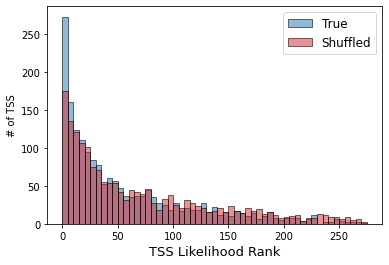

In [598]:
true_sets_ranks = []
shuff_sets_ranks = []
for (_, y_name), tss_prob_ranks in trial_result_dict.items():
    if y_name == 'true':
        true_sets_ranks.extend(tss_prob_ranks)
    else:
        shuff_sets_ranks.extend(tss_prob_ranks)

_, ax = plt.subplots()
        
sns.histplot(true_sets_ranks, color='tab:blue', binwidth=5, alpha=0.5, label='True', ax=ax)
sns.histplot(shuff_sets_ranks, color='tab:red', binwidth=5, alpha=0.5, label='Shuffled', ax=ax)
ax.legend(fontsize=12)
ax.set_xlabel('TSS Likelihood Rank', fontsize=13)
ax.set_ylabel('# of TSS')

## One-Hot w/Shape

In [170]:
with_shape_result_dict = run_trial(
    n_upstream=250, n_downstream=25, shape=True,
    n_units=32, activation='tanh',
    n_neurons=(32, 16), dropout_rate=(0.1, 0.1), 
    neg_weight_adjust=1.05,
    batch_size=32, epochs=50, patience=10
)

Epoch 1/50
38/38 [==============================] - 4s 116ms/step - loss: 0.6839 - accuracy: 0.7094 - auroc: 0.5813 - auprc: 0.0057 - fn: 878.0000 - fp: 95054.0000 - tn: 233586.0000 - tp: 578.0000 - val_loss: 0.5911 - val_accuracy: 0.8166 - val_auroc: 0.6551 - val_auprc: 0.0079 - val_fn: 227.0000 - val_fp: 14912.0000 - val_tn: 67258.0000 - val_tp: 127.0000
Epoch 2/50
38/38 [==============================] - 3s 90ms/step - loss: 0.6490 - accuracy: 0.6686 - auroc: 0.6700 - auprc: 0.0093 - fn: 612.0000 - fp: 108798.0000 - tn: 219842.0000 - tp: 844.0000 - val_loss: 0.5362 - val_accuracy: 0.7055 - val_auroc: 0.7050 - val_auprc: 0.0115 - val_fn: 141.0000 - val_fp: 24166.0000 - val_tn: 58004.0000 - val_tp: 213.0000
Epoch 3/50
38/38 [==============================] - 3s 89ms/step - loss: 0.6188 - accuracy: 0.6676 - auroc: 0.7176 - auprc: 0.0121 - fn: 497.0000 - fp: 109239.0000 - tn: 219401.0000 - tp: 959.0000 - val_loss: 0.6248 - val_accuracy: 0.6265 - val_auroc: 0.7394 - val_auprc: 0.0146 - v

Epoch 6/50
38/38 [==============================] - 3s 88ms/step - loss: 0.6791 - accuracy: 0.6750 - auroc: 0.5940 - auprc: 0.0063 - fn: 799.0000 - fp: 106471.0000 - tn: 222169.0000 - tp: 657.0000 - val_loss: 0.6712 - val_accuracy: 0.5637 - val_auroc: 0.6071 - val_auprc: 0.0063 - val_fn: 141.0000 - val_fp: 35861.0000 - val_tn: 46309.0000 - val_tp: 213.0000
Epoch 7/50
38/38 [==============================] - 3s 85ms/step - loss: 0.6732 - accuracy: 0.6643 - auroc: 0.6142 - auprc: 0.0067 - fn: 753.0000 - fp: 110065.0000 - tn: 218575.0000 - tp: 703.0000 - val_loss: 0.6820 - val_accuracy: 0.5052 - val_auroc: 0.6087 - val_auprc: 0.0063 - val_fn: 128.0000 - val_fp: 40701.0000 - val_tn: 41469.0000 - val_tp: 226.0000
Epoch 8/50
38/38 [==============================] - 3s 84ms/step - loss: 0.6680 - accuracy: 0.6583 - auroc: 0.6268 - auprc: 0.0072 - fn: 693.0000 - fp: 112097.0000 - tn: 216543.0000 - tp: 763.0000 - val_loss: 0.6069 - val_accuracy: 0.7025 - val_auroc: 0.6207 - val_auprc: 0.0069 - v

Epoch 29/50
38/38 [==============================] - 3s 85ms/step - loss: 0.5106 - accuracy: 0.6859 - auroc: 0.8137 - auprc: 0.0157 - fn: 291.0000 - fp: 103396.0000 - tn: 225244.0000 - tp: 1165.0000 - val_loss: 0.4814 - val_accuracy: 0.6984 - val_auroc: 0.7196 - val_auprc: 0.0134 - val_fn: 130.0000 - val_fp: 24756.0000 - val_tn: 57414.0000 - val_tp: 224.0000
Epoch 30/50
38/38 [==============================] - 3s 85ms/step - loss: 0.4876 - accuracy: 0.7029 - auroc: 0.8317 - auprc: 0.0177 - fn: 270.0000 - fp: 97797.0000 - tn: 230843.0000 - tp: 1186.0000 - val_loss: 0.4135 - val_accuracy: 0.7556 - val_auroc: 0.7175 - val_auprc: 0.0141 - val_fn: 160.0000 - val_fp: 20010.0000 - val_tn: 62160.0000 - val_tp: 194.0000
Epoch 31/50
38/38 [==============================] - 3s 84ms/step - loss: 0.4867 - accuracy: 0.7063 - auroc: 0.8318 - auprc: 0.0178 - fn: 274.0000 - fp: 96674.0000 - tn: 231966.0000 - tp: 1182.0000 - val_loss: 0.6150 - val_accuracy: 0.5685 - val_auroc: 0.6704 - val_auprc: 0.0094

Epoch 2/50
38/38 [==============================] - 3s 87ms/step - loss: 0.6524 - accuracy: 0.6805 - auroc: 0.6645 - auprc: 0.0103 - fn: 658.0000 - fp: 104797.0000 - tn: 223836.0000 - tp: 805.0000 - val_loss: 0.5978 - val_accuracy: 0.6878 - val_auroc: 0.6878 - val_auprc: 0.0092 - val_fn: 141.0000 - val_fp: 25621.0000 - val_tn: 56556.0000 - val_tp: 206.0000
Epoch 3/50
38/38 [==============================] - 3s 87ms/step - loss: 0.6150 - accuracy: 0.6987 - auroc: 0.7222 - auprc: 0.0146 - fn: 522.0000 - fp: 98932.0000 - tn: 229701.0000 - tp: 941.0000 - val_loss: 0.5867 - val_accuracy: 0.7025 - val_auroc: 0.7219 - val_auprc: 0.0113 - val_fn: 128.0000 - val_fp: 24426.0000 - val_tn: 57751.0000 - val_tp: 219.0000
Epoch 4/50
38/38 [==============================] - 3s 86ms/step - loss: 0.5874 - accuracy: 0.7184 - auroc: 0.7567 - auprc: 0.0187 - fn: 473.0000 - fp: 92475.0000 - tn: 236158.0000 - tp: 990.0000 - val_loss: 0.4734 - val_accuracy: 0.7989 - val_auroc: 0.7455 - val_auprc: 0.0147 - val

Epoch 25/50
38/38 [==============================] - 3s 87ms/step - loss: 0.3995 - accuracy: 0.8197 - auroc: 0.8999 - auprc: 0.0545 - fn: 253.0000 - fp: 59256.0000 - tn: 269377.0000 - tp: 1210.0000 - val_loss: 0.3487 - val_accuracy: 0.8394 - val_auroc: 0.8016 - val_auprc: 0.0346 - val_fn: 139.0000 - val_fp: 13112.0000 - val_tn: 69065.0000 - val_tp: 208.0000
Epoch 26/50
38/38 [==============================] - 3s 86ms/step - loss: 0.3924 - accuracy: 0.8237 - auroc: 0.9034 - auprc: 0.0538 - fn: 254.0000 - fp: 57953.0000 - tn: 270680.0000 - tp: 1209.0000 - val_loss: 0.3779 - val_accuracy: 0.8214 - val_auroc: 0.8056 - val_auprc: 0.0356 - val_fn: 124.0000 - val_fp: 14618.0000 - val_tn: 67559.0000 - val_tp: 223.0000
Epoch 27/50
38/38 [==============================] - 3s 86ms/step - loss: 0.3848 - accuracy: 0.8185 - auroc: 0.9065 - auprc: 0.0522 - fn: 224.0000 - fp: 59683.0000 - tn: 268950.0000 - tp: 1239.0000 - val_loss: 0.3092 - val_accuracy: 0.8581 - val_auroc: 0.8056 - val_auprc: 0.0340 

Epoch 48/50
38/38 [==============================] - 3s 86ms/step - loss: 0.2548 - accuracy: 0.8645 - auroc: 0.9516 - auprc: 0.0676 - fn: 80.0000 - fp: 44657.0000 - tn: 283976.0000 - tp: 1383.0000 - val_loss: 0.2757 - val_accuracy: 0.8665 - val_auroc: 0.7813 - val_auprc: 0.0371 - val_fn: 153.0000 - val_fp: 10861.0000 - val_tn: 71316.0000 - val_tp: 194.0000
Epoch 49/50
38/38 [==============================] - 3s 85ms/step - loss: 0.2481 - accuracy: 0.8680 - auroc: 0.9531 - auprc: 0.0716 - fn: 75.0000 - fp: 43507.0000 - tn: 285126.0000 - tp: 1388.0000 - val_loss: 0.2958 - val_accuracy: 0.8586 - val_auroc: 0.7833 - val_auprc: 0.0360 - val_fn: 146.0000 - val_fp: 11526.0000 - val_tn: 70651.0000 - val_tp: 201.0000
Epoch 50/50
38/38 [==============================] - 3s 88ms/step - loss: 0.2561 - accuracy: 0.8609 - auroc: 0.9508 - auprc: 0.0705 - fn: 79.0000 - fp: 45836.0000 - tn: 282797.0000 - tp: 1384.0000 - val_loss: 0.3191 - val_accuracy: 0.8462 - val_auroc: 0.7803 - val_auprc: 0.0341 - v

Epoch 21/50
38/38 [==============================] - 3s 83ms/step - loss: 0.5485 - accuracy: 0.6912 - auroc: 0.7901 - auprc: 0.0140 - fn: 340.0000 - fp: 101598.0000 - tn: 227035.0000 - tp: 1123.0000 - val_loss: 0.5769 - val_accuracy: 0.6773 - val_auroc: 0.6974 - val_auprc: 0.0101 - val_fn: 124.0000 - val_fp: 26507.0000 - val_tn: 55670.0000 - val_tp: 223.0000
Epoch 22/50
38/38 [==============================] - 3s 84ms/step - loss: 0.5439 - accuracy: 0.7148 - auroc: 0.7947 - auprc: 0.0152 - fn: 392.0000 - fp: 93750.0000 - tn: 234883.0000 - tp: 1071.0000 - val_loss: 0.6566 - val_accuracy: 0.6015 - val_auroc: 0.6855 - val_auprc: 0.0108 - val_fn: 114.0000 - val_fp: 32775.0000 - val_tn: 49402.0000 - val_tp: 233.0000
Epoch 23/50
38/38 [==============================] - 3s 84ms/step - loss: 0.5391 - accuracy: 0.6898 - auroc: 0.7978 - auprc: 0.0154 - fn: 329.0000 - fp: 102054.0000 - tn: 226579.0000 - tp: 1134.0000 - val_loss: 0.4732 - val_accuracy: 0.7150 - val_auroc: 0.6982 - val_auprc: 0.009

Epoch 20/50
38/38 [==============================] - 3s 85ms/step - loss: 0.4232 - accuracy: 0.8096 - auroc: 0.8868 - auprc: 0.0520 - fn: 267.0000 - fp: 62593.0000 - tn: 266062.0000 - tp: 1174.0000 - val_loss: 0.2965 - val_accuracy: 0.8762 - val_auroc: 0.8463 - val_auprc: 0.0704 - val_fn: 138.0000 - val_fp: 10076.0000 - val_tn: 72079.0000 - val_tp: 231.0000
Epoch 21/50
38/38 [==============================] - 3s 85ms/step - loss: 0.4122 - accuracy: 0.8177 - auroc: 0.8928 - auprc: 0.0552 - fn: 268.0000 - fp: 59922.0000 - tn: 268733.0000 - tp: 1173.0000 - val_loss: 0.3565 - val_accuracy: 0.8379 - val_auroc: 0.8481 - val_auprc: 0.0706 - val_fn: 117.0000 - val_fp: 13263.0000 - val_tn: 68892.0000 - val_tp: 252.0000
Epoch 22/50
38/38 [==============================] - 3s 86ms/step - loss: 0.4061 - accuracy: 0.8168 - auroc: 0.8962 - auprc: 0.0546 - fn: 250.0000 - fp: 60228.0000 - tn: 268427.0000 - tp: 1191.0000 - val_loss: 0.3259 - val_accuracy: 0.8508 - val_auroc: 0.8466 - val_auprc: 0.0698 

Epoch 4/50
38/38 [==============================] - 3s 85ms/step - loss: 0.6874 - accuracy: 0.7791 - auroc: 0.5613 - auprc: 0.0054 - fn: 1037.0000 - fp: 71884.0000 - tn: 256771.0000 - tp: 404.0000 - val_loss: 0.6501 - val_accuracy: 0.7552 - val_auroc: 0.5349 - val_auprc: 0.0047 - val_fn: 260.0000 - val_fp: 19945.0000 - val_tn: 62210.0000 - val_tp: 109.0000
Epoch 5/50
38/38 [==============================] - 3s 86ms/step - loss: 0.6854 - accuracy: 0.7343 - auroc: 0.5704 - auprc: 0.0055 - fn: 943.0000 - fp: 86761.0000 - tn: 241894.0000 - tp: 498.0000 - val_loss: 0.6521 - val_accuracy: 0.6877 - val_auroc: 0.5428 - val_auprc: 0.0048 - val_fn: 228.0000 - val_fp: 25544.0000 - val_tn: 56611.0000 - val_tp: 141.0000
Epoch 6/50
38/38 [==============================] - 3s 86ms/step - loss: 0.6840 - accuracy: 0.7394 - auroc: 0.5842 - auprc: 0.0058 - fn: 904.0000 - fp: 85121.0000 - tn: 243534.0000 - tp: 537.0000 - val_loss: 0.6245 - val_accuracy: 0.7714 - val_auroc: 0.5405 - val_auprc: 0.0048 - val

Epoch 27/50
38/38 [==============================] - 3s 88ms/step - loss: 0.5532 - accuracy: 0.6903 - auroc: 0.7871 - auprc: 0.0152 - fn: 377.0000 - fp: 101857.0000 - tn: 226798.0000 - tp: 1064.0000 - val_loss: 0.4939 - val_accuracy: 0.7243 - val_auroc: 0.6706 - val_auprc: 0.0082 - val_fn: 176.0000 - val_fp: 22576.0000 - val_tn: 59579.0000 - val_tp: 193.0000
Epoch 28/50
38/38 [==============================] - 3s 85ms/step - loss: 0.5444 - accuracy: 0.7119 - auroc: 0.7939 - auprc: 0.0158 - fn: 395.0000 - fp: 94700.0000 - tn: 233955.0000 - tp: 1046.0000 - val_loss: 0.4748 - val_accuracy: 0.7244 - val_auroc: 0.6700 - val_auprc: 0.0081 - val_fn: 177.0000 - val_fp: 22564.0000 - val_tn: 59591.0000 - val_tp: 192.0000
Epoch 29/50
38/38 [==============================] - 3s 85ms/step - loss: 0.5438 - accuracy: 0.6927 - auroc: 0.7927 - auprc: 0.0152 - fn: 354.0000 - fp: 101088.0000 - tn: 227567.0000 - tp: 1087.0000 - val_loss: 0.5006 - val_accuracy: 0.7147 - val_auroc: 0.6840 - val_auprc: 0.009

Epoch 2/50
38/38 [==============================] - 3s 90ms/step - loss: 0.6503 - accuracy: 0.6795 - auroc: 0.6727 - auprc: 0.0103 - fn: 620.0000 - fp: 105185.0000 - tn: 223462.0000 - tp: 829.0000 - val_loss: 0.5727 - val_accuracy: 0.6926 - val_auroc: 0.7272 - val_auprc: 0.0184 - val_fn: 134.0000 - val_fp: 25238.0000 - val_tn: 56925.0000 - val_tp: 227.0000
Epoch 3/50
38/38 [==============================] - 3s 89ms/step - loss: 0.6121 - accuracy: 0.6828 - auroc: 0.7275 - auprc: 0.0132 - fn: 481.0000 - fp: 104235.0000 - tn: 224412.0000 - tp: 968.0000 - val_loss: 0.5618 - val_accuracy: 0.7187 - val_auroc: 0.7680 - val_auprc: 0.0306 - val_fn: 102.0000 - val_fp: 23109.0000 - val_tn: 59054.0000 - val_tp: 259.0000
Epoch 4/50
38/38 [==============================] - 3s 88ms/step - loss: 0.5825 - accuracy: 0.7184 - auroc: 0.7613 - auprc: 0.0177 - fn: 460.0000 - fp: 92482.0000 - tn: 236165.0000 - tp: 989.0000 - val_loss: 0.5698 - val_accuracy: 0.7111 - val_auroc: 0.7782 - val_auprc: 0.0290 - va

Epoch 25/50
38/38 [==============================] - 3s 87ms/step - loss: 0.3903 - accuracy: 0.8162 - auroc: 0.9029 - auprc: 0.0519 - fn: 234.0000 - fp: 60435.0000 - tn: 268212.0000 - tp: 1215.0000 - val_loss: 0.3577 - val_accuracy: 0.8241 - val_auroc: 0.8317 - val_auprc: 0.0615 - val_fn: 115.0000 - val_fp: 14399.0000 - val_tn: 67764.0000 - val_tp: 246.0000
Epoch 26/50
38/38 [==============================] - 3s 87ms/step - loss: 0.3821 - accuracy: 0.8142 - auroc: 0.9070 - auprc: 0.0534 - fn: 204.0000 - fp: 61139.0000 - tn: 267508.0000 - tp: 1245.0000 - val_loss: 0.4065 - val_accuracy: 0.7977 - val_auroc: 0.8354 - val_auprc: 0.0604 - val_fn: 98.0000 - val_fp: 16599.0000 - val_tn: 65564.0000 - val_tp: 263.0000
Epoch 27/50
38/38 [==============================] - 3s 87ms/step - loss: 0.3740 - accuracy: 0.8189 - auroc: 0.9108 - auprc: 0.0511 - fn: 196.0000 - fp: 59585.0000 - tn: 269062.0000 - tp: 1253.0000 - val_loss: 0.4012 - val_accuracy: 0.8014 - val_auroc: 0.8314 - val_auprc: 0.0651 -

Epoch 48/50
38/38 [==============================] - 3s 88ms/step - loss: 0.2808 - accuracy: 0.8438 - auroc: 0.9426 - auprc: 0.0604 - fn: 88.0000 - fp: 51462.0000 - tn: 277185.0000 - tp: 1361.0000 - val_loss: 0.2905 - val_accuracy: 0.8529 - val_auroc: 0.8149 - val_auprc: 0.0530 - val_fn: 131.0000 - val_fp: 12012.0000 - val_tn: 70151.0000 - val_tp: 230.0000
Epoch 49/50
38/38 [==============================] - 3s 86ms/step - loss: 0.2632 - accuracy: 0.8574 - auroc: 0.9475 - auprc: 0.0622 - fn: 78.0000 - fp: 47002.0000 - tn: 281645.0000 - tp: 1371.0000 - val_loss: 0.3473 - val_accuracy: 0.8270 - val_auroc: 0.8103 - val_auprc: 0.0523 - val_fn: 130.0000 - val_fp: 14147.0000 - val_tn: 68016.0000 - val_tp: 231.0000
Epoch 50/50
38/38 [==============================] - 3s 87ms/step - loss: 0.2775 - accuracy: 0.8419 - auroc: 0.9433 - auprc: 0.0593 - fn: 93.0000 - fp: 52107.0000 - tn: 276540.0000 - tp: 1356.0000 - val_loss: 0.3178 - val_accuracy: 0.8345 - val_auroc: 0.8054 - val_auprc: 0.0484 - v

Epoch 21/50
38/38 [==============================] - 3s 86ms/step - loss: 0.5524 - accuracy: 0.7250 - auroc: 0.7873 - auprc: 0.0138 - fn: 425.0000 - fp: 90355.0000 - tn: 238292.0000 - tp: 1024.0000 - val_loss: 0.5567 - val_accuracy: 0.6851 - val_auroc: 0.7371 - val_auprc: 0.0136 - val_fn: 121.0000 - val_fp: 25867.0000 - val_tn: 56296.0000 - val_tp: 240.0000
Epoch 22/50
38/38 [==============================] - 3s 87ms/step - loss: 0.5443 - accuracy: 0.7073 - auroc: 0.7933 - auprc: 0.0147 - fn: 384.0000 - fp: 96250.0000 - tn: 232397.0000 - tp: 1065.0000 - val_loss: 0.5006 - val_accuracy: 0.7259 - val_auroc: 0.7296 - val_auprc: 0.0129 - val_fn: 141.0000 - val_fp: 22475.0000 - val_tn: 59688.0000 - val_tp: 220.0000
Epoch 23/50
38/38 [==============================] - 3s 87ms/step - loss: 0.5371 - accuracy: 0.7274 - auroc: 0.8005 - auprc: 0.0160 - fn: 394.0000 - fp: 89595.0000 - tn: 239052.0000 - tp: 1055.0000 - val_loss: 0.4515 - val_accuracy: 0.7620 - val_auroc: 0.7315 - val_auprc: 0.0129 

Epoch 11/50
38/38 [==============================] - 3s 90ms/step - loss: 0.5104 - accuracy: 0.7699 - auroc: 0.8286 - auprc: 0.0302 - fn: 364.0000 - fp: 75595.0000 - tn: 253070.0000 - tp: 1067.0000 - val_loss: 0.4583 - val_accuracy: 0.7836 - val_auroc: 0.7931 - val_auprc: 0.0304 - val_fn: 123.0000 - val_fp: 17734.0000 - val_tn: 64411.0000 - val_tp: 256.0000
Epoch 12/50
38/38 [==============================] - 3s 91ms/step - loss: 0.4970 - accuracy: 0.7823 - auroc: 0.8396 - auprc: 0.0334 - fn: 368.0000 - fp: 71500.0000 - tn: 257165.0000 - tp: 1063.0000 - val_loss: 0.4474 - val_accuracy: 0.7940 - val_auroc: 0.7886 - val_auprc: 0.0290 - val_fn: 131.0000 - val_fp: 16873.0000 - val_tn: 65272.0000 - val_tp: 248.0000
Epoch 13/50
38/38 [==============================] - 3s 88ms/step - loss: 0.4856 - accuracy: 0.7941 - auroc: 0.8475 - auprc: 0.0359 - fn: 352.0000 - fp: 67626.0000 - tn: 261039.0000 - tp: 1079.0000 - val_loss: 0.5426 - val_accuracy: 0.7260 - val_auroc: 0.7998 - val_auprc: 0.0285 

Epoch 34/50
38/38 [==============================] - 3s 87ms/step - loss: 0.3423 - accuracy: 0.8270 - auroc: 0.9230 - auprc: 0.0525 - fn: 166.0000 - fp: 56947.0000 - tn: 271718.0000 - tp: 1265.0000 - val_loss: 0.3646 - val_accuracy: 0.8165 - val_auroc: 0.8036 - val_auprc: 0.0348 - val_fn: 137.0000 - val_fp: 15006.0000 - val_tn: 67139.0000 - val_tp: 242.0000
Epoch 35/50
38/38 [==============================] - 3s 87ms/step - loss: 0.3312 - accuracy: 0.8321 - auroc: 0.9273 - auprc: 0.0555 - fn: 153.0000 - fp: 55274.0000 - tn: 273391.0000 - tp: 1278.0000 - val_loss: 0.3693 - val_accuracy: 0.8182 - val_auroc: 0.7954 - val_auprc: 0.0375 - val_fn: 136.0000 - val_fp: 14866.0000 - val_tn: 67279.0000 - val_tp: 243.0000
Epoch 36/50
38/38 [==============================] - 3s 86ms/step - loss: 0.3154 - accuracy: 0.8375 - auroc: 0.9327 - auprc: 0.0565 - fn: 127.0000 - fp: 53499.0000 - tn: 275166.0000 - tp: 1304.0000 - val_loss: 0.2802 - val_accuracy: 0.8605 - val_auroc: 0.7904 - val_auprc: 0.0354 

Epoch 7/50
38/38 [==============================] - 3s 87ms/step - loss: 0.6608 - accuracy: 0.6475 - auroc: 0.6463 - auprc: 0.0074 - fn: 607.0000 - fp: 115767.0000 - tn: 212898.0000 - tp: 824.0000 - val_loss: 0.6364 - val_accuracy: 0.6151 - val_auroc: 0.6481 - val_auprc: 0.0074 - val_fn: 148.0000 - val_fp: 31619.0000 - val_tn: 50526.0000 - val_tp: 231.0000
Epoch 8/50
38/38 [==============================] - 3s 87ms/step - loss: 0.6581 - accuracy: 0.6501 - auroc: 0.6489 - auprc: 0.0075 - fn: 622.0000 - fp: 114880.0000 - tn: 213785.0000 - tp: 809.0000 - val_loss: 0.5785 - val_accuracy: 0.7103 - val_auroc: 0.6396 - val_auprc: 0.0072 - val_fn: 196.0000 - val_fp: 23712.0000 - val_tn: 58433.0000 - val_tp: 183.0000
Epoch 9/50
38/38 [==============================] - 3s 85ms/step - loss: 0.6507 - accuracy: 0.6702 - auroc: 0.6667 - auprc: 0.0081 - fn: 595.0000 - fp: 108256.0000 - tn: 220409.0000 - tp: 836.0000 - val_loss: 0.6899 - val_accuracy: 0.5475 - val_auroc: 0.6507 - val_auprc: 0.0075 - v

Epoch 30/50
38/38 [==============================] - 3s 87ms/step - loss: 0.4921 - accuracy: 0.7017 - auroc: 0.8289 - auprc: 0.0177 - fn: 271.0000 - fp: 98197.0000 - tn: 230468.0000 - tp: 1160.0000 - val_loss: 0.5242 - val_accuracy: 0.6646 - val_auroc: 0.7376 - val_auprc: 0.0122 - val_fn: 117.0000 - val_fp: 27562.0000 - val_tn: 54583.0000 - val_tp: 262.0000
Epoch 31/50
38/38 [==============================] - 3s 88ms/step - loss: 0.4896 - accuracy: 0.6996 - auroc: 0.8312 - auprc: 0.0179 - fn: 266.0000 - fp: 98896.0000 - tn: 229769.0000 - tp: 1165.0000 - val_loss: 0.4738 - val_accuracy: 0.7065 - val_auroc: 0.7365 - val_auprc: 0.0124 - val_fn: 132.0000 - val_fp: 24092.0000 - val_tn: 58053.0000 - val_tp: 247.0000
Epoch 32/50
38/38 [==============================] - 3s 89ms/step - loss: 0.4727 - accuracy: 0.7131 - auroc: 0.8415 - auprc: 0.0184 - fn: 248.0000 - fp: 94447.0000 - tn: 234218.0000 - tp: 1183.0000 - val_loss: 0.5551 - val_accuracy: 0.6321 - val_auroc: 0.7300 - val_auprc: 0.0112 

Text(0, 0.5, '# of TSS')

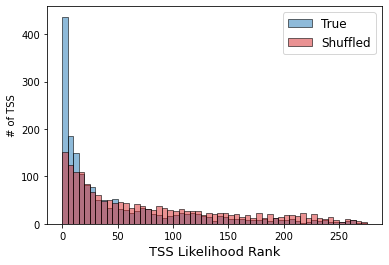

In [18]:
true_sets_ranks = []
shuff_sets_ranks = []
for (_, y_name), tss_prob_ranks in with_shape_result_dict.items():
    if y_name == 'true':
        true_sets_ranks.extend(tss_prob_ranks)
    else:
        shuff_sets_ranks.extend(tss_prob_ranks)

_, ax = plt.subplots()
        
sns.histplot(true_sets_ranks, color='tab:blue', binwidth=5, alpha=0.5, label='True', ax=ax)
sns.histplot(shuff_sets_ranks, color='tab:red', binwidth=5, alpha=0.5, label='Shuffled', ax=ax)
ax.legend(fontsize=12)
ax.set_xlabel('TSS Likelihood Rank', fontsize=13)
ax.set_ylabel('# of TSS')

## One-Hot w/Shape and w/Motifs

In [155]:
shape_motifs_result_dict = run_trial(
    n_upstream=250, n_downstream=25, shape=True, motifs=True,
    n_units=32, activation='tanh',
    n_neurons=(32, 16), dropout_rate=(0.1, 0.1), 
    neg_weight_adjust=1.05,
    batch_size=32, epochs=50, patience=10
)

Epoch 1/50
38/38 [==============================] - 5s 126ms/step - loss: 0.6824 - accuracy: 0.7090 - auroc: 0.5898 - auprc: 0.0058 - fn: 871.0000 - fp: 95184.0000 - tn: 233456.0000 - tp: 585.0000 - val_loss: 0.6134 - val_accuracy: 0.7163 - val_auroc: 0.6535 - val_auprc: 0.0076 - val_fn: 189.0000 - val_fp: 23221.0000 - val_tn: 58949.0000 - val_tp: 165.0000
Epoch 2/50
38/38 [==============================] - 4s 98ms/step - loss: 0.6428 - accuracy: 0.6603 - auroc: 0.6825 - auprc: 0.0090 - fn: 586.0000 - fp: 111551.0000 - tn: 217089.0000 - tp: 870.0000 - val_loss: 0.5835 - val_accuracy: 0.6277 - val_auroc: 0.7212 - val_auprc: 0.0106 - val_fn: 101.0000 - val_fp: 30619.0000 - val_tn: 51551.0000 - val_tp: 253.0000
Epoch 3/50
38/38 [==============================] - 4s 95ms/step - loss: 0.5993 - accuracy: 0.6744 - auroc: 0.7432 - auprc: 0.0142 - fn: 447.0000 - fp: 107041.0000 - tn: 221599.0000 - tp: 1009.0000 - val_loss: 0.5562 - val_accuracy: 0.6836 - val_auroc: 0.7680 - val_auprc: 0.0159 - 

Epoch 24/50
38/38 [==============================] - 4s 105ms/step - loss: 0.3004 - accuracy: 0.8441 - auroc: 0.9397 - auprc: 0.0750 - fn: 137.0000 - fp: 51326.0000 - tn: 277314.0000 - tp: 1319.0000 - val_loss: 0.3192 - val_accuracy: 0.8469 - val_auroc: 0.8263 - val_auprc: 0.0391 - val_fn: 130.0000 - val_fp: 12501.0000 - val_tn: 69669.0000 - val_tp: 224.0000
Epoch 25/50
38/38 [==============================] - 4s 118ms/step - loss: 0.2879 - accuracy: 0.8501 - auroc: 0.9433 - auprc: 0.0765 - fn: 109.0000 - fp: 49375.0000 - tn: 279265.0000 - tp: 1347.0000 - val_loss: 0.2688 - val_accuracy: 0.8710 - val_auroc: 0.8185 - val_auprc: 0.0380 - val_fn: 142.0000 - val_fp: 10507.0000 - val_tn: 71663.0000 - val_tp: 212.0000
Epoch 26/50
38/38 [==============================] - 4s 106ms/step - loss: 0.2672 - accuracy: 0.8659 - auroc: 0.9498 - auprc: 0.0785 - fn: 103.0000 - fp: 44150.0000 - tn: 284490.0000 - tp: 1353.0000 - val_loss: 0.3320 - val_accuracy: 0.8444 - val_auroc: 0.8228 - val_auprc: 0.03

Epoch 47/50
38/38 [==============================] - 4s 93ms/step - loss: 0.1713 - accuracy: 0.9110 - auroc: 0.9720 - auprc: 0.1016 - fn: 30.0000 - fp: 29351.0000 - tn: 299289.0000 - tp: 1426.0000 - val_loss: 0.1986 - val_accuracy: 0.9170 - val_auroc: 0.7884 - val_auprc: 0.0345 - val_fn: 173.0000 - val_fp: 6676.0000 - val_tn: 75494.0000 - val_tp: 181.0000
Epoch 48/50
38/38 [==============================] - 4s 94ms/step - loss: 0.1668 - accuracy: 0.9131 - auroc: 0.9732 - auprc: 0.1062 - fn: 37.0000 - fp: 28643.0000 - tn: 299997.0000 - tp: 1419.0000 - val_loss: 0.2448 - val_accuracy: 0.8976 - val_auroc: 0.7899 - val_auprc: 0.0349 - val_fn: 171.0000 - val_fp: 8281.0000 - val_tn: 73889.0000 - val_tp: 183.0000
Epoch 49/50
38/38 [==============================] - 4s 99ms/step - loss: 0.1602 - accuracy: 0.9151 - auroc: 0.9746 - auprc: 0.1102 - fn: 23.0000 - fp: 27987.0000 - tn: 300653.0000 - tp: 1433.0000 - val_loss: 0.1804 - val_accuracy: 0.9277 - val_auroc: 0.7745 - val_auprc: 0.0347 - val

Epoch 20/50
38/38 [==============================] - 4s 94ms/step - loss: 0.4747 - accuracy: 0.7138 - auroc: 0.8403 - auprc: 0.0191 - fn: 265.0000 - fp: 94216.0000 - tn: 234424.0000 - tp: 1191.0000 - val_loss: 0.4777 - val_accuracy: 0.7054 - val_auroc: 0.7084 - val_auprc: 0.0113 - val_fn: 152.0000 - val_fp: 24157.0000 - val_tn: 58013.0000 - val_tp: 202.0000
Epoch 21/50
38/38 [==============================] - 4s 94ms/step - loss: 0.4615 - accuracy: 0.7314 - auroc: 0.8491 - auprc: 0.0190 - fn: 238.0000 - fp: 88410.0000 - tn: 240230.0000 - tp: 1218.0000 - val_loss: 0.4122 - val_accuracy: 0.7569 - val_auroc: 0.7044 - val_auprc: 0.0107 - val_fn: 164.0000 - val_fp: 19900.0000 - val_tn: 62270.0000 - val_tp: 190.0000
Epoch 22/50
38/38 [==============================] - 4s 114ms/step - loss: 0.4522 - accuracy: 0.7302 - auroc: 0.8542 - auprc: 0.0190 - fn: 220.0000 - fp: 88849.0000 - tn: 239791.0000 - tp: 1236.0000 - val_loss: 0.4266 - val_accuracy: 0.7442 - val_auroc: 0.6975 - val_auprc: 0.0104

Epoch 43/50
38/38 [==============================] - 3s 90ms/step - loss: 0.2855 - accuracy: 0.8297 - auroc: 0.9310 - auprc: 0.0362 - fn: 67.0000 - fp: 56139.0000 - tn: 272501.0000 - tp: 1389.0000 - val_loss: 0.3431 - val_accuracy: 0.8173 - val_auroc: 0.6626 - val_auprc: 0.0081 - val_fn: 212.0000 - val_fp: 14869.0000 - val_tn: 67301.0000 - val_tp: 142.0000
Epoch 1/50
38/38 [==============================] - 5s 125ms/step - loss: 0.6867 - accuracy: 0.8307 - auroc: 0.5694 - auprc: 0.0062 - fn: 1135.0000 - fp: 54734.0000 - tn: 273899.0000 - tp: 328.0000 - val_loss: 0.6102 - val_accuracy: 0.8360 - val_auroc: 0.6227 - val_auprc: 0.0066 - val_fn: 245.0000 - val_fp: 13289.0000 - val_tn: 68888.0000 - val_tp: 102.0000
Epoch 2/50
38/38 [==============================] - 4s 93ms/step - loss: 0.6530 - accuracy: 0.7137 - auroc: 0.6680 - auprc: 0.0084 - fn: 714.0000 - fp: 93797.0000 - tn: 234836.0000 - tp: 749.0000 - val_loss: 0.6009 - val_accuracy: 0.6169 - val_auroc: 0.6960 - val_auprc: 0.0092 - v

Epoch 23/50
38/38 [==============================] - 4s 95ms/step - loss: 0.3110 - accuracy: 0.8421 - auroc: 0.9347 - auprc: 0.0620 - fn: 139.0000 - fp: 51978.0000 - tn: 276655.0000 - tp: 1324.0000 - val_loss: 0.3181 - val_accuracy: 0.8428 - val_auroc: 0.8457 - val_auprc: 0.0486 - val_fn: 113.0000 - val_fp: 12857.0000 - val_tn: 69320.0000 - val_tp: 234.0000
Epoch 24/50
38/38 [==============================] - 4s 105ms/step - loss: 0.2964 - accuracy: 0.8488 - auroc: 0.9399 - auprc: 0.0703 - fn: 142.0000 - fp: 49780.0000 - tn: 278853.0000 - tp: 1321.0000 - val_loss: 0.3701 - val_accuracy: 0.8130 - val_auroc: 0.8452 - val_auprc: 0.0456 - val_fn: 98.0000 - val_fp: 15334.0000 - val_tn: 66843.0000 - val_tp: 249.0000
Epoch 25/50
38/38 [==============================] - 4s 105ms/step - loss: 0.2858 - accuracy: 0.8507 - auroc: 0.9436 - auprc: 0.0680 - fn: 106.0000 - fp: 49172.0000 - tn: 279461.0000 - tp: 1357.0000 - val_loss: 0.3832 - val_accuracy: 0.8066 - val_auroc: 0.8377 - val_auprc: 0.0464

Epoch 46/50
38/38 [==============================] - 4s 95ms/step - loss: 0.1735 - accuracy: 0.9076 - auroc: 0.9712 - auprc: 0.0955 - fn: 36.0000 - fp: 30453.0000 - tn: 298180.0000 - tp: 1427.0000 - val_loss: 0.2002 - val_accuracy: 0.9148 - val_auroc: 0.7978 - val_auprc: 0.0432 - val_fn: 166.0000 - val_fp: 6863.0000 - val_tn: 75314.0000 - val_tp: 181.0000
Epoch 47/50
38/38 [==============================] - 4s 108ms/step - loss: 0.1620 - accuracy: 0.9134 - auroc: 0.9732 - auprc: 0.0982 - fn: 19.0000 - fp: 28578.0000 - tn: 300055.0000 - tp: 1444.0000 - val_loss: 0.1705 - val_accuracy: 0.9282 - val_auroc: 0.7763 - val_auprc: 0.0415 - val_fn: 193.0000 - val_fp: 5736.0000 - val_tn: 76441.0000 - val_tp: 154.0000
Epoch 48/50
38/38 [==============================] - 4s 106ms/step - loss: 0.1569 - accuracy: 0.9180 - auroc: 0.9744 - auprc: 0.1003 - fn: 28.0000 - fp: 27026.0000 - tn: 301607.0000 - tp: 1435.0000 - val_loss: 0.2068 - val_accuracy: 0.9147 - val_auroc: 0.7885 - val_auprc: 0.0414 - v

Epoch 19/50
38/38 [==============================] - 5s 121ms/step - loss: 0.5052 - accuracy: 0.7362 - auroc: 0.8237 - auprc: 0.0175 - fn: 330.0000 - fp: 86749.0000 - tn: 241884.0000 - tp: 1133.0000 - val_loss: 0.5025 - val_accuracy: 0.7218 - val_auroc: 0.7022 - val_auprc: 0.0100 - val_fn: 146.0000 - val_fp: 22812.0000 - val_tn: 59365.0000 - val_tp: 201.0000
Epoch 20/50
38/38 [==============================] - 4s 113ms/step - loss: 0.4932 - accuracy: 0.7275 - auroc: 0.8322 - auprc: 0.0187 - fn: 284.0000 - fp: 89673.0000 - tn: 238960.0000 - tp: 1179.0000 - val_loss: 0.5256 - val_accuracy: 0.6927 - val_auroc: 0.7076 - val_auprc: 0.0096 - val_fn: 128.0000 - val_fp: 25233.0000 - val_tn: 56944.0000 - val_tp: 219.0000
Epoch 21/50
38/38 [==============================] - 5s 132ms/step - loss: 0.4931 - accuracy: 0.7243 - auroc: 0.8297 - auprc: 0.0174 - fn: 291.0000 - fp: 90712.0000 - tn: 237921.0000 - tp: 1172.0000 - val_loss: 0.4600 - val_accuracy: 0.7381 - val_auroc: 0.6997 - val_auprc: 0.00

Epoch 42/50
38/38 [==============================] - 4s 103ms/step - loss: 0.3034 - accuracy: 0.8197 - auroc: 0.9253 - auprc: 0.0340 - fn: 92.0000 - fp: 59415.0000 - tn: 269218.0000 - tp: 1371.0000 - val_loss: 0.3473 - val_accuracy: 0.8188 - val_auroc: 0.6742 - val_auprc: 0.0086 - val_fn: 204.0000 - val_fp: 14752.0000 - val_tn: 67425.0000 - val_tp: 143.0000
Epoch 43/50
38/38 [==============================] - 3s 90ms/step - loss: 0.2925 - accuracy: 0.8286 - auroc: 0.9293 - auprc: 0.0352 - fn: 68.0000 - fp: 56522.0000 - tn: 272111.0000 - tp: 1395.0000 - val_loss: 0.3726 - val_accuracy: 0.8051 - val_auroc: 0.6578 - val_auprc: 0.0082 - val_fn: 202.0000 - val_fp: 15884.0000 - val_tn: 66293.0000 - val_tp: 145.0000
Epoch 44/50
38/38 [==============================] - 3s 91ms/step - loss: 0.2836 - accuracy: 0.8354 - auroc: 0.9330 - auprc: 0.0376 - fn: 67.0000 - fp: 54254.0000 - tn: 274379.0000 - tp: 1396.0000 - val_loss: 0.3544 - val_accuracy: 0.8179 - val_auroc: 0.6619 - val_auprc: 0.0081 - 

Epoch 15/50
38/38 [==============================] - 4s 100ms/step - loss: 0.3769 - accuracy: 0.8172 - auroc: 0.9086 - auprc: 0.0529 - fn: 197.0000 - fp: 60148.0000 - tn: 268507.0000 - tp: 1244.0000 - val_loss: 0.4072 - val_accuracy: 0.7949 - val_auroc: 0.8276 - val_auprc: 0.0428 - val_fn: 106.0000 - val_fp: 16818.0000 - val_tn: 65337.0000 - val_tp: 263.0000
Epoch 16/50
38/38 [==============================] - 4s 92ms/step - loss: 0.3653 - accuracy: 0.8188 - auroc: 0.9133 - auprc: 0.0554 - fn: 204.0000 - fp: 59624.0000 - tn: 269031.0000 - tp: 1237.0000 - val_loss: 0.3626 - val_accuracy: 0.8196 - val_auroc: 0.8366 - val_auprc: 0.0490 - val_fn: 110.0000 - val_fp: 14779.0000 - val_tn: 67376.0000 - val_tp: 259.0000
Epoch 17/50
38/38 [==============================] - 4s 96ms/step - loss: 0.3567 - accuracy: 0.8199 - auroc: 0.9176 - auprc: 0.0546 - fn: 173.0000 - fp: 59276.0000 - tn: 269379.0000 - tp: 1268.0000 - val_loss: 0.3163 - val_accuracy: 0.8460 - val_auroc: 0.8339 - val_auprc: 0.0502

Epoch 38/50
38/38 [==============================] - 3s 90ms/step - loss: 0.2018 - accuracy: 0.8914 - auroc: 0.9631 - auprc: 0.0781 - fn: 37.0000 - fp: 35808.0000 - tn: 292847.0000 - tp: 1404.0000 - val_loss: 0.2839 - val_accuracy: 0.8719 - val_auroc: 0.7933 - val_auprc: 0.0459 - val_fn: 160.0000 - val_fp: 10412.0000 - val_tn: 71743.0000 - val_tp: 209.0000
Epoch 39/50
38/38 [==============================] - 3s 88ms/step - loss: 0.2050 - accuracy: 0.8895 - auroc: 0.9625 - auprc: 0.0769 - fn: 46.0000 - fp: 36441.0000 - tn: 292214.0000 - tp: 1395.0000 - val_loss: 0.2889 - val_accuracy: 0.8686 - val_auroc: 0.8051 - val_auprc: 0.0448 - val_fn: 157.0000 - val_fp: 10688.0000 - val_tn: 71467.0000 - val_tp: 212.0000
Epoch 40/50
38/38 [==============================] - 3s 86ms/step - loss: 0.2002 - accuracy: 0.8920 - auroc: 0.9638 - auprc: 0.0785 - fn: 41.0000 - fp: 35593.0000 - tn: 293062.0000 - tp: 1400.0000 - val_loss: 0.3390 - val_accuracy: 0.8498 - val_auroc: 0.8049 - val_auprc: 0.0451 - v

Epoch 11/50
38/38 [==============================] - 5s 124ms/step - loss: 0.5578 - accuracy: 0.7318 - auroc: 0.7795 - auprc: 0.0131 - fn: 444.0000 - fp: 88102.0000 - tn: 240553.0000 - tp: 997.0000 - val_loss: 0.5420 - val_accuracy: 0.6986 - val_auroc: 0.7147 - val_auprc: 0.0118 - val_fn: 144.0000 - val_fp: 24726.0000 - val_tn: 57429.0000 - val_tp: 225.0000
Epoch 12/50
38/38 [==============================] - 4s 109ms/step - loss: 0.5463 - accuracy: 0.7120 - auroc: 0.7914 - auprc: 0.0154 - fn: 375.0000 - fp: 94678.0000 - tn: 233977.0000 - tp: 1066.0000 - val_loss: 0.5860 - val_accuracy: 0.6654 - val_auroc: 0.7075 - val_auprc: 0.0116 - val_fn: 138.0000 - val_fp: 27471.0000 - val_tn: 54684.0000 - val_tp: 231.0000
Epoch 13/50
38/38 [==============================] - 4s 109ms/step - loss: 0.5395 - accuracy: 0.7129 - auroc: 0.7961 - auprc: 0.0145 - fn: 349.0000 - fp: 94422.0000 - tn: 234233.0000 - tp: 1092.0000 - val_loss: 0.4804 - val_accuracy: 0.7533 - val_auroc: 0.7022 - val_auprc: 0.011

Epoch 34/50
38/38 [==============================] - 4s 106ms/step - loss: 0.3092 - accuracy: 0.8129 - auroc: 0.9227 - auprc: 0.0329 - fn: 70.0000 - fp: 61705.0000 - tn: 266950.0000 - tp: 1371.0000 - val_loss: 0.3323 - val_accuracy: 0.8165 - val_auroc: 0.6688 - val_auprc: 0.0090 - val_fn: 222.0000 - val_fp: 14921.0000 - val_tn: 67234.0000 - val_tp: 147.0000
Epoch 35/50
38/38 [==============================] - 4s 106ms/step - loss: 0.3080 - accuracy: 0.8162 - auroc: 0.9246 - auprc: 0.0353 - fn: 86.0000 - fp: 60571.0000 - tn: 268084.0000 - tp: 1355.0000 - val_loss: 0.3748 - val_accuracy: 0.7966 - val_auroc: 0.6579 - val_auprc: 0.0088 - val_fn: 212.0000 - val_fp: 16570.0000 - val_tn: 65585.0000 - val_tp: 157.0000
Epoch 36/50
38/38 [==============================] - 4s 105ms/step - loss: 0.3204 - accuracy: 0.8078 - auroc: 0.9205 - auprc: 0.0336 - fn: 91.0000 - fp: 63354.0000 - tn: 265301.0000 - tp: 1350.0000 - val_loss: 0.4019 - val_accuracy: 0.7795 - val_auroc: 0.6659 - val_auprc: 0.0090 

Epoch 7/50
38/38 [==============================] - 4s 108ms/step - loss: 0.5037 - accuracy: 0.7547 - auroc: 0.8316 - auprc: 0.0255 - fn: 339.0000 - fp: 80650.0000 - tn: 247997.0000 - tp: 1110.0000 - val_loss: 0.4107 - val_accuracy: 0.7912 - val_auroc: 0.8192 - val_auprc: 0.0417 - val_fn: 121.0000 - val_fp: 17111.0000 - val_tn: 65052.0000 - val_tp: 240.0000
Epoch 8/50
38/38 [==============================] - 5s 121ms/step - loss: 0.4781 - accuracy: 0.7753 - auroc: 0.8513 - auprc: 0.0319 - fn: 323.0000 - fp: 73847.0000 - tn: 254800.0000 - tp: 1126.0000 - val_loss: 0.5166 - val_accuracy: 0.7299 - val_auroc: 0.8243 - val_auprc: 0.0464 - val_fn: 86.0000 - val_fp: 22205.0000 - val_tn: 59958.0000 - val_tp: 275.0000
Epoch 9/50
38/38 [==============================] - 4s 115ms/step - loss: 0.4658 - accuracy: 0.7782 - auroc: 0.8586 - auprc: 0.0329 - fn: 308.0000 - fp: 72911.0000 - tn: 255736.0000 - tp: 1141.0000 - val_loss: 0.3767 - val_accuracy: 0.8181 - val_auroc: 0.8351 - val_auprc: 0.0556 -

Epoch 30/50
38/38 [==============================] - 4s 117ms/step - loss: 0.2455 - accuracy: 0.8612 - auroc: 0.9520 - auprc: 0.0700 - fn: 72.0000 - fp: 45739.0000 - tn: 282908.0000 - tp: 1377.0000 - val_loss: 0.2344 - val_accuracy: 0.8828 - val_auroc: 0.8100 - val_auprc: 0.0729 - val_fn: 144.0000 - val_fp: 9524.0000 - val_tn: 72639.0000 - val_tp: 217.0000
Epoch 31/50
38/38 [==============================] - 4s 109ms/step - loss: 0.2390 - accuracy: 0.8698 - auroc: 0.9531 - auprc: 0.0702 - fn: 72.0000 - fp: 42921.0000 - tn: 285726.0000 - tp: 1377.0000 - val_loss: 0.2674 - val_accuracy: 0.8697 - val_auroc: 0.8158 - val_auprc: 0.0703 - val_fn: 135.0000 - val_fp: 10619.0000 - val_tn: 71544.0000 - val_tp: 226.0000
Epoch 32/50
38/38 [==============================] - 4s 108ms/step - loss: 0.2297 - accuracy: 0.8743 - auroc: 0.9553 - auprc: 0.0690 - fn: 54.0000 - fp: 41448.0000 - tn: 287199.0000 - tp: 1395.0000 - val_loss: 0.2586 - val_accuracy: 0.8733 - val_auroc: 0.8153 - val_auprc: 0.0698 -

Epoch 3/50
38/38 [==============================] - 4s 111ms/step - loss: 0.6787 - accuracy: 0.6830 - auroc: 0.5825 - auprc: 0.0058 - fn: 852.0000 - fp: 103796.0000 - tn: 224851.0000 - tp: 597.0000 - val_loss: 0.6200 - val_accuracy: 0.6778 - val_auroc: 0.6109 - val_auprc: 0.0060 - val_fn: 193.0000 - val_fp: 26398.0000 - val_tn: 55765.0000 - val_tp: 168.0000
Epoch 4/50
38/38 [==============================] - 4s 108ms/step - loss: 0.6651 - accuracy: 0.6118 - auroc: 0.6195 - auprc: 0.0064 - fn: 657.0000 - fp: 127488.0000 - tn: 201159.0000 - tp: 792.0000 - val_loss: 0.6440 - val_accuracy: 0.4698 - val_auroc: 0.6287 - val_auprc: 0.0063 - val_fn: 101.0000 - val_fp: 43653.0000 - val_tn: 38510.0000 - val_tp: 260.0000
Epoch 5/50
38/38 [==============================] - 4s 110ms/step - loss: 0.6489 - accuracy: 0.5256 - auroc: 0.6471 - auprc: 0.0068 - fn: 457.0000 - fp: 156155.0000 - tn: 172492.0000 - tp: 992.0000 - val_loss: 0.5837 - val_accuracy: 0.5899 - val_auroc: 0.6196 - val_auprc: 0.0061 

Epoch 26/50
38/38 [==============================] - 4s 108ms/step - loss: 0.4291 - accuracy: 0.7429 - auroc: 0.8691 - auprc: 0.0220 - fn: 202.0000 - fp: 84669.0000 - tn: 243978.0000 - tp: 1247.0000 - val_loss: 0.5420 - val_accuracy: 0.6782 - val_auroc: 0.6973 - val_auprc: 0.0099 - val_fn: 150.0000 - val_fp: 26410.0000 - val_tn: 55753.0000 - val_tp: 211.0000
Epoch 27/50
38/38 [==============================] - 4s 107ms/step - loss: 0.4333 - accuracy: 0.7349 - auroc: 0.8657 - auprc: 0.0217 - fn: 192.0000 - fp: 87310.0000 - tn: 241337.0000 - tp: 1257.0000 - val_loss: 0.3861 - val_accuracy: 0.7768 - val_auroc: 0.6926 - val_auprc: 0.0097 - val_fn: 193.0000 - val_fp: 18227.0000 - val_tn: 63936.0000 - val_tp: 168.0000
Epoch 28/50
38/38 [==============================] - 4s 111ms/step - loss: 0.4150 - accuracy: 0.7457 - auroc: 0.8756 - auprc: 0.0222 - fn: 170.0000 - fp: 83788.0000 - tn: 244859.0000 - tp: 1279.0000 - val_loss: 0.4384 - val_accuracy: 0.7356 - val_auroc: 0.6944 - val_auprc: 0.00

Epoch 49/50
38/38 [==============================] - 5s 129ms/step - loss: 0.2703 - accuracy: 0.8373 - auroc: 0.9398 - auprc: 0.0435 - fn: 57.0000 - fp: 53664.0000 - tn: 274983.0000 - tp: 1392.0000 - val_loss: 0.3026 - val_accuracy: 0.8432 - val_auroc: 0.6587 - val_auprc: 0.0082 - val_fn: 232.0000 - val_fp: 12708.0000 - val_tn: 69455.0000 - val_tp: 129.0000
Epoch 50/50
38/38 [==============================] - 5s 119ms/step - loss: 0.2721 - accuracy: 0.8402 - auroc: 0.9397 - auprc: 0.0439 - fn: 62.0000 - fp: 52689.0000 - tn: 275958.0000 - tp: 1387.0000 - val_loss: 0.3070 - val_accuracy: 0.8443 - val_auroc: 0.6628 - val_auprc: 0.0092 - val_fn: 219.0000 - val_fp: 12630.0000 - val_tn: 69533.0000 - val_tp: 142.0000
Epoch 1/50
38/38 [==============================] - 7s 180ms/step - loss: 0.6847 - accuracy: 0.7768 - auroc: 0.5777 - auprc: 0.0054 - fn: 1011.0000 - fp: 72650.0000 - tn: 256015.0000 - tp: 420.0000 - val_loss: 0.6160 - val_accuracy: 0.7589 - val_auroc: 0.6417 - val_auprc: 0.0080 

Epoch 22/50
38/38 [==============================] - 5s 119ms/step - loss: 0.3193 - accuracy: 0.8517 - auroc: 0.9347 - auprc: 0.0714 - fn: 152.0000 - fp: 48799.0000 - tn: 279866.0000 - tp: 1279.0000 - val_loss: 0.2996 - val_accuracy: 0.8606 - val_auroc: 0.8451 - val_auprc: 0.0448 - val_fn: 127.0000 - val_fp: 11379.0000 - val_tn: 70766.0000 - val_tp: 252.0000
Epoch 23/50
38/38 [==============================] - 4s 118ms/step - loss: 0.3251 - accuracy: 0.8469 - auroc: 0.9319 - auprc: 0.0699 - fn: 155.0000 - fp: 50368.0000 - tn: 278297.0000 - tp: 1276.0000 - val_loss: 0.3565 - val_accuracy: 0.8372 - val_auroc: 0.8392 - val_auprc: 0.0468 - val_fn: 126.0000 - val_fp: 13312.0000 - val_tn: 68833.0000 - val_tp: 253.0000
Epoch 24/50
38/38 [==============================] - 5s 119ms/step - loss: 0.3017 - accuracy: 0.8592 - auroc: 0.9403 - auprc: 0.0663 - fn: 145.0000 - fp: 46339.0000 - tn: 282326.0000 - tp: 1286.0000 - val_loss: 0.3700 - val_accuracy: 0.8283 - val_auroc: 0.8492 - val_auprc: 0.04

Epoch 45/50
38/38 [==============================] - 4s 111ms/step - loss: 0.1705 - accuracy: 0.9116 - auroc: 0.9722 - auprc: 0.0949 - fn: 34.0000 - fp: 29157.0000 - tn: 299508.0000 - tp: 1397.0000 - val_loss: 0.2246 - val_accuracy: 0.9084 - val_auroc: 0.8065 - val_auprc: 0.0365 - val_fn: 176.0000 - val_fp: 7385.0000 - val_tn: 74760.0000 - val_tp: 203.0000
Epoch 46/50
38/38 [==============================] - 4s 114ms/step - loss: 0.1705 - accuracy: 0.9133 - auroc: 0.9724 - auprc: 0.0962 - fn: 39.0000 - fp: 28591.0000 - tn: 300074.0000 - tp: 1392.0000 - val_loss: 0.2260 - val_accuracy: 0.9071 - val_auroc: 0.8016 - val_auprc: 0.0353 - val_fn: 168.0000 - val_fp: 7496.0000 - val_tn: 74649.0000 - val_tp: 211.0000
Epoch 47/50
38/38 [==============================] - 4s 112ms/step - loss: 0.1782 - accuracy: 0.9085 - auroc: 0.9712 - auprc: 0.0954 - fn: 38.0000 - fp: 30175.0000 - tn: 298490.0000 - tp: 1393.0000 - val_loss: 0.2105 - val_accuracy: 0.9112 - val_auroc: 0.7989 - val_auprc: 0.0357 - 

Epoch 18/50
38/38 [==============================] - 4s 114ms/step - loss: 0.5011 - accuracy: 0.7170 - auroc: 0.8262 - auprc: 0.0184 - fn: 320.0000 - fp: 93103.0000 - tn: 235562.0000 - tp: 1111.0000 - val_loss: 0.4240 - val_accuracy: 0.7681 - val_auroc: 0.6865 - val_auprc: 0.0096 - val_fn: 199.0000 - val_fp: 18940.0000 - val_tn: 63205.0000 - val_tp: 180.0000
Epoch 19/50
38/38 [==============================] - 4s 117ms/step - loss: 0.4867 - accuracy: 0.7268 - auroc: 0.8372 - auprc: 0.0203 - fn: 294.0000 - fp: 89901.0000 - tn: 238764.0000 - tp: 1137.0000 - val_loss: 0.4713 - val_accuracy: 0.7399 - val_auroc: 0.6685 - val_auprc: 0.0091 - val_fn: 190.0000 - val_fp: 21272.0000 - val_tn: 60873.0000 - val_tp: 189.0000
Epoch 20/50
38/38 [==============================] - 4s 113ms/step - loss: 0.4712 - accuracy: 0.7428 - auroc: 0.8482 - auprc: 0.0214 - fn: 287.0000 - fp: 84613.0000 - tn: 244052.0000 - tp: 1144.0000 - val_loss: 0.4465 - val_accuracy: 0.7454 - val_auroc: 0.6831 - val_auprc: 0.00

Epoch 41/50
38/38 [==============================] - 4s 113ms/step - loss: 0.2534 - accuracy: 0.8573 - auroc: 0.9476 - auprc: 0.0479 - fn: 63.0000 - fp: 47045.0000 - tn: 281620.0000 - tp: 1368.0000 - val_loss: 0.3223 - val_accuracy: 0.8426 - val_auroc: 0.6324 - val_auprc: 0.0079 - val_fn: 246.0000 - val_fp: 12747.0000 - val_tn: 69398.0000 - val_tp: 133.0000
Epoch 42/50
38/38 [==============================] - 4s 111ms/step - loss: 0.2553 - accuracy: 0.8569 - auroc: 0.9475 - auprc: 0.0492 - fn: 68.0000 - fp: 47179.0000 - tn: 281486.0000 - tp: 1363.0000 - val_loss: 0.2939 - val_accuracy: 0.8595 - val_auroc: 0.6416 - val_auprc: 0.0083 - val_fn: 252.0000 - val_fp: 11345.0000 - val_tn: 70800.0000 - val_tp: 127.0000
Epoch 43/50
38/38 [==============================] - 4s 113ms/step - loss: 0.2526 - accuracy: 0.8581 - auroc: 0.9497 - auprc: 0.0525 - fn: 60.0000 - fp: 46785.0000 - tn: 281880.0000 - tp: 1371.0000 - val_loss: 0.3671 - val_accuracy: 0.8164 - val_auroc: 0.6345 - val_auprc: 0.0080 

Text(0, 0.5, '# of TSS')

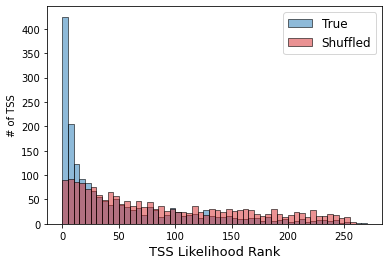

In [156]:
true_sets_ranks = []
shuff_sets_ranks = []
for (_, y_name), tss_prob_ranks in shape_motifs_result_dict.items():
    if y_name == 'true':
        true_sets_ranks.extend(tss_prob_ranks)
    else:
        shuff_sets_ranks.extend(tss_prob_ranks)

_, ax = plt.subplots()
        
sns.histplot(true_sets_ranks, color='tab:blue', binwidth=5, alpha=0.5, label='True', ax=ax)
sns.histplot(shuff_sets_ranks, color='tab:red', binwidth=5, alpha=0.5, label='Shuffled', ax=ax)
ax.legend(fontsize=12)
ax.set_xlabel('TSS Likelihood Rank', fontsize=13)
ax.set_ylabel('# of TSS')

## One-Hot w/Motifs

In [166]:
motifs_result_dict = run_trial(
    n_upstream=250, n_downstream=25, shape=False, motifs=True,
    n_units=32, activation='tanh',
    n_neurons=(32, 16), dropout_rate=(0.1, 0.1), 
    neg_weight_adjust=1.05,
    batch_size=32, epochs=50, patience=10
)

Epoch 1/50
38/38 [==============================] - 6s 157ms/step - loss: 0.6828 - accuracy: 0.7527 - auroc: 0.5846 - auprc: 0.0061 - fn: 971.0000 - fp: 80655.0000 - tn: 247985.0000 - tp: 485.0000 - val_loss: 0.6354 - val_accuracy: 0.6308 - val_auroc: 0.6688 - val_auprc: 0.0073 - val_fn: 133.0000 - val_fp: 30331.0000 - val_tn: 51839.0000 - val_tp: 221.0000
Epoch 2/50
38/38 [==============================] - 5s 127ms/step - loss: 0.6432 - accuracy: 0.6256 - auroc: 0.6798 - auprc: 0.0089 - fn: 543.0000 - fp: 123036.0000 - tn: 205604.0000 - tp: 913.0000 - val_loss: 0.5638 - val_accuracy: 0.6640 - val_auroc: 0.7132 - val_auprc: 0.0092 - val_fn: 120.0000 - val_fp: 27608.0000 - val_tn: 54562.0000 - val_tp: 234.0000
Epoch 3/50
38/38 [==============================] - 5s 127ms/step - loss: 0.6160 - accuracy: 0.6407 - auroc: 0.7226 - auprc: 0.0113 - fn: 442.0000 - fp: 118162.0000 - tn: 210478.0000 - tp: 1014.0000 - val_loss: 0.5556 - val_accuracy: 0.6617 - val_auroc: 0.7403 - val_auprc: 0.0117 

Epoch 24/50
38/38 [==============================] - 4s 112ms/step - loss: 0.3805 - accuracy: 0.8169 - auroc: 0.9084 - auprc: 0.0595 - fn: 228.0000 - fp: 60203.0000 - tn: 268437.0000 - tp: 1228.0000 - val_loss: 0.3192 - val_accuracy: 0.8490 - val_auroc: 0.8478 - val_auprc: 0.0424 - val_fn: 116.0000 - val_fp: 12345.0000 - val_tn: 69825.0000 - val_tp: 238.0000
Epoch 25/50
38/38 [==============================] - 4s 110ms/step - loss: 0.3747 - accuracy: 0.8237 - auroc: 0.9105 - auprc: 0.0621 - fn: 226.0000 - fp: 57978.0000 - tn: 270662.0000 - tp: 1230.0000 - val_loss: 0.4240 - val_accuracy: 0.7879 - val_auroc: 0.8500 - val_auprc: 0.0405 - val_fn: 88.0000 - val_fp: 17412.0000 - val_tn: 64758.0000 - val_tp: 266.0000
Epoch 26/50
38/38 [==============================] - 5s 119ms/step - loss: 0.3646 - accuracy: 0.8196 - auroc: 0.9153 - auprc: 0.0628 - fn: 191.0000 - fp: 59362.0000 - tn: 269278.0000 - tp: 1265.0000 - val_loss: 0.3180 - val_accuracy: 0.8499 - val_auroc: 0.8315 - val_auprc: 0.040

Epoch 47/50
38/38 [==============================] - 5s 121ms/step - loss: 0.2669 - accuracy: 0.8512 - auroc: 0.9478 - auprc: 0.0785 - fn: 83.0000 - fp: 49043.0000 - tn: 279597.0000 - tp: 1373.0000 - val_loss: 0.2761 - val_accuracy: 0.8583 - val_auroc: 0.8164 - val_auprc: 0.0416 - val_fn: 142.0000 - val_fp: 11555.0000 - val_tn: 70615.0000 - val_tp: 212.0000
Epoch 48/50
38/38 [==============================] - 4s 107ms/step - loss: 0.2586 - accuracy: 0.8543 - auroc: 0.9501 - auprc: 0.0777 - fn: 80.0000 - fp: 48028.0000 - tn: 280612.0000 - tp: 1376.0000 - val_loss: 0.2891 - val_accuracy: 0.8562 - val_auroc: 0.8092 - val_auprc: 0.0395 - val_fn: 139.0000 - val_fp: 11726.0000 - val_tn: 70444.0000 - val_tp: 215.0000
Epoch 49/50
38/38 [==============================] - 4s 116ms/step - loss: 0.2496 - accuracy: 0.8613 - auroc: 0.9530 - auprc: 0.0797 - fn: 84.0000 - fp: 45698.0000 - tn: 282942.0000 - tp: 1372.0000 - val_loss: 0.2726 - val_accuracy: 0.8651 - val_auroc: 0.8184 - val_auprc: 0.0411 

Epoch 20/50
38/38 [==============================] - 4s 106ms/step - loss: 0.5324 - accuracy: 0.7046 - auroc: 0.7999 - auprc: 0.0152 - fn: 362.0000 - fp: 97163.0000 - tn: 231477.0000 - tp: 1094.0000 - val_loss: 0.5034 - val_accuracy: 0.7089 - val_auroc: 0.7311 - val_auprc: 0.0125 - val_fn: 127.0000 - val_fp: 23896.0000 - val_tn: 58274.0000 - val_tp: 227.0000
Epoch 21/50
38/38 [==============================] - 4s 116ms/step - loss: 0.5304 - accuracy: 0.7006 - auroc: 0.8010 - auprc: 0.0151 - fn: 335.0000 - fp: 98507.0000 - tn: 230133.0000 - tp: 1121.0000 - val_loss: 0.5335 - val_accuracy: 0.6687 - val_auroc: 0.7273 - val_auprc: 0.0129 - val_fn: 118.0000 - val_fp: 27220.0000 - val_tn: 54950.0000 - val_tp: 236.0000
Epoch 22/50
38/38 [==============================] - 4s 106ms/step - loss: 0.5222 - accuracy: 0.6913 - auroc: 0.8069 - auprc: 0.0155 - fn: 328.0000 - fp: 101560.0000 - tn: 227080.0000 - tp: 1128.0000 - val_loss: 0.4717 - val_accuracy: 0.7145 - val_auroc: 0.7178 - val_auprc: 0.0

Epoch 5/50
38/38 [==============================] - 4s 108ms/step - loss: 0.5627 - accuracy: 0.6933 - auroc: 0.7805 - auprc: 0.0189 - fn: 398.0000 - fp: 100836.0000 - tn: 227797.0000 - tp: 1065.0000 - val_loss: 0.5403 - val_accuracy: 0.7022 - val_auroc: 0.7804 - val_auprc: 0.0240 - val_fn: 97.0000 - val_fp: 24478.0000 - val_tn: 57699.0000 - val_tp: 250.0000
Epoch 6/50
38/38 [==============================] - 4s 108ms/step - loss: 0.5400 - accuracy: 0.7254 - auroc: 0.8021 - auprc: 0.0222 - fn: 393.0000 - fp: 90237.0000 - tn: 238396.0000 - tp: 1070.0000 - val_loss: 0.4899 - val_accuracy: 0.7311 - val_auroc: 0.8171 - val_auprc: 0.0284 - val_fn: 86.0000 - val_fp: 22101.0000 - val_tn: 60076.0000 - val_tp: 261.0000
Epoch 7/50
38/38 [==============================] - 4s 113ms/step - loss: 0.5137 - accuracy: 0.7356 - auroc: 0.8245 - auprc: 0.0300 - fn: 349.0000 - fp: 86912.0000 - tn: 241721.0000 - tp: 1114.0000 - val_loss: 0.4956 - val_accuracy: 0.7387 - val_auroc: 0.8208 - val_auprc: 0.0313 -

Epoch 28/50
38/38 [==============================] - 5s 123ms/step - loss: 0.3543 - accuracy: 0.8247 - auroc: 0.9194 - auprc: 0.0659 - fn: 193.0000 - fp: 57685.0000 - tn: 270948.0000 - tp: 1270.0000 - val_loss: 0.3572 - val_accuracy: 0.8265 - val_auroc: 0.8505 - val_auprc: 0.0477 - val_fn: 97.0000 - val_fp: 14219.0000 - val_tn: 67958.0000 - val_tp: 250.0000
Epoch 29/50
38/38 [==============================] - 4s 111ms/step - loss: 0.3474 - accuracy: 0.8290 - auroc: 0.9226 - auprc: 0.0651 - fn: 195.0000 - fp: 56240.0000 - tn: 272393.0000 - tp: 1268.0000 - val_loss: 0.3285 - val_accuracy: 0.8418 - val_auroc: 0.8488 - val_auprc: 0.0450 - val_fn: 102.0000 - val_fp: 12956.0000 - val_tn: 69221.0000 - val_tp: 245.0000
Epoch 30/50
38/38 [==============================] - 4s 112ms/step - loss: 0.3448 - accuracy: 0.8249 - auroc: 0.9233 - auprc: 0.0653 - fn: 187.0000 - fp: 57608.0000 - tn: 271025.0000 - tp: 1276.0000 - val_loss: 0.3063 - val_accuracy: 0.8473 - val_auroc: 0.8493 - val_auprc: 0.044

Epoch 1/50
38/38 [==============================] - 5s 129ms/step - loss: 0.6922 - accuracy: 0.7055 - auroc: 0.5193 - auprc: 0.0047 - fn: 1004.0000 - fp: 96208.0000 - tn: 232425.0000 - tp: 459.0000 - val_loss: 0.6450 - val_accuracy: 0.8444 - val_auroc: 0.5573 - val_auprc: 0.0052 - val_fn: 277.0000 - val_fp: 12563.0000 - val_tn: 69614.0000 - val_tp: 70.0000
Epoch 2/50
38/38 [==============================] - 4s 93ms/step - loss: 0.6862 - accuracy: 0.7845 - auroc: 0.5594 - auprc: 0.0056 - fn: 1064.0000 - fp: 70080.0000 - tn: 258553.0000 - tp: 399.0000 - val_loss: 0.6420 - val_accuracy: 0.7159 - val_auroc: 0.5773 - val_auprc: 0.0053 - val_fn: 222.0000 - val_fp: 23223.0000 - val_tn: 58954.0000 - val_tp: 125.0000
Epoch 3/50
38/38 [==============================] - 4s 94ms/step - loss: 0.6794 - accuracy: 0.6646 - auroc: 0.5890 - auprc: 0.0059 - fn: 803.0000 - fp: 109910.0000 - tn: 218723.0000 - tp: 660.0000 - val_loss: 0.6887 - val_accuracy: 0.4014 - val_auroc: 0.5852 - val_auprc: 0.0053 - v

Epoch 8/50
38/38 [==============================] - 3s 92ms/step - loss: 0.4994 - accuracy: 0.7656 - auroc: 0.8366 - auprc: 0.0306 - fn: 350.0000 - fp: 77029.0000 - tn: 251626.0000 - tp: 1091.0000 - val_loss: 0.3893 - val_accuracy: 0.8287 - val_auroc: 0.8185 - val_auprc: 0.0328 - val_fn: 136.0000 - val_fp: 14002.0000 - val_tn: 68153.0000 - val_tp: 233.0000
Epoch 9/50
38/38 [==============================] - 3s 90ms/step - loss: 0.4846 - accuracy: 0.7709 - auroc: 0.8464 - auprc: 0.0315 - fn: 351.0000 - fp: 75274.0000 - tn: 253381.0000 - tp: 1090.0000 - val_loss: 0.4080 - val_accuracy: 0.8132 - val_auroc: 0.8206 - val_auprc: 0.0371 - val_fn: 122.0000 - val_fp: 15293.0000 - val_tn: 66862.0000 - val_tp: 247.0000
Epoch 10/50
38/38 [==============================] - 4s 99ms/step - loss: 0.4783 - accuracy: 0.7814 - auroc: 0.8518 - auprc: 0.0337 - fn: 330.0000 - fp: 71836.0000 - tn: 256819.0000 - tp: 1111.0000 - val_loss: 0.3717 - val_accuracy: 0.8387 - val_auroc: 0.8223 - val_auprc: 0.0379 - 

Epoch 9/50
38/38 [==============================] - 3s 92ms/step - loss: 0.5827 - accuracy: 0.7444 - auroc: 0.7555 - auprc: 0.0132 - fn: 514.0000 - fp: 83869.0000 - tn: 244786.0000 - tp: 927.0000 - val_loss: 0.5490 - val_accuracy: 0.7571 - val_auroc: 0.7304 - val_auprc: 0.0120 - val_fn: 156.0000 - val_fp: 19889.0000 - val_tn: 62266.0000 - val_tp: 213.0000
Epoch 10/50
38/38 [==============================] - 3s 89ms/step - loss: 0.5738 - accuracy: 0.7497 - auroc: 0.7646 - auprc: 0.0150 - fn: 501.0000 - fp: 82124.0000 - tn: 246531.0000 - tp: 940.0000 - val_loss: 0.5123 - val_accuracy: 0.7599 - val_auroc: 0.7348 - val_auprc: 0.0116 - val_fn: 151.0000 - val_fp: 19662.0000 - val_tn: 62493.0000 - val_tp: 218.0000
Epoch 11/50
38/38 [==============================] - 3s 91ms/step - loss: 0.5654 - accuracy: 0.7441 - auroc: 0.7753 - auprc: 0.0151 - fn: 481.0000 - fp: 83976.0000 - tn: 244679.0000 - tp: 960.0000 - val_loss: 0.4343 - val_accuracy: 0.7998 - val_auroc: 0.7260 - val_auprc: 0.0119 - va

Epoch 15/50
38/38 [==============================] - 3s 85ms/step - loss: 0.4321 - accuracy: 0.7980 - auroc: 0.8799 - auprc: 0.0432 - fn: 314.0000 - fp: 66376.0000 - tn: 262271.0000 - tp: 1135.0000 - val_loss: 0.4708 - val_accuracy: 0.7600 - val_auroc: 0.8436 - val_auprc: 0.0551 - val_fn: 84.0000 - val_fp: 19722.0000 - val_tn: 62441.0000 - val_tp: 277.0000
Epoch 16/50
38/38 [==============================] - 3s 85ms/step - loss: 0.4266 - accuracy: 0.7842 - auroc: 0.8828 - auprc: 0.0474 - fn: 269.0000 - fp: 70982.0000 - tn: 257665.0000 - tp: 1180.0000 - val_loss: 0.4389 - val_accuracy: 0.7749 - val_auroc: 0.8446 - val_auprc: 0.0569 - val_fn: 80.0000 - val_fp: 18497.0000 - val_tn: 63666.0000 - val_tp: 281.0000
Epoch 17/50
38/38 [==============================] - 3s 88ms/step - loss: 0.4156 - accuracy: 0.7938 - auroc: 0.8888 - auprc: 0.0472 - fn: 273.0000 - fp: 67790.0000 - tn: 260857.0000 - tp: 1176.0000 - val_loss: 0.4546 - val_accuracy: 0.7621 - val_auroc: 0.8460 - val_auprc: 0.0595 - 

Epoch 7/50
38/38 [==============================] - 4s 111ms/step - loss: 0.6184 - accuracy: 0.6123 - auroc: 0.7057 - auprc: 0.0099 - fn: 467.0000 - fp: 127511.0000 - tn: 201136.0000 - tp: 982.0000 - val_loss: 0.6057 - val_accuracy: 0.6213 - val_auroc: 0.7096 - val_auprc: 0.0116 - val_fn: 123.0000 - val_fp: 31126.0000 - val_tn: 51037.0000 - val_tp: 238.0000
Epoch 8/50
38/38 [==============================] - 4s 97ms/step - loss: 0.5929 - accuracy: 0.6970 - auroc: 0.7437 - auprc: 0.0117 - fn: 496.0000 - fp: 99526.0000 - tn: 229121.0000 - tp: 953.0000 - val_loss: 0.5147 - val_accuracy: 0.7753 - val_auroc: 0.7426 - val_auprc: 0.0131 - val_fn: 158.0000 - val_fp: 18385.0000 - val_tn: 63778.0000 - val_tp: 203.0000
Epoch 9/50
38/38 [==============================] - 4s 95ms/step - loss: 0.5759 - accuracy: 0.7210 - auroc: 0.7628 - auprc: 0.0126 - fn: 479.0000 - fp: 91622.0000 - tn: 237025.0000 - tp: 970.0000 - val_loss: 0.5437 - val_accuracy: 0.7299 - val_auroc: 0.7444 - val_auprc: 0.0133 - va

Epoch 7/50
38/38 [==============================] - 4s 103ms/step - loss: 0.5003 - accuracy: 0.7574 - auroc: 0.8351 - auprc: 0.0329 - fn: 345.0000 - fp: 79737.0000 - tn: 248928.0000 - tp: 1086.0000 - val_loss: 0.4086 - val_accuracy: 0.8085 - val_auroc: 0.8174 - val_auprc: 0.0305 - val_fn: 130.0000 - val_fp: 15677.0000 - val_tn: 66468.0000 - val_tp: 249.0000
Epoch 8/50
38/38 [==============================] - 4s 98ms/step - loss: 0.4835 - accuracy: 0.7818 - auroc: 0.8477 - auprc: 0.0388 - fn: 344.0000 - fp: 71695.0000 - tn: 256970.0000 - tp: 1087.0000 - val_loss: 0.4791 - val_accuracy: 0.7561 - val_auroc: 0.8248 - val_auprc: 0.0341 - val_fn: 104.0000 - val_fp: 20022.0000 - val_tn: 62123.0000 - val_tp: 275.0000
Epoch 9/50
38/38 [==============================] - 4s 98ms/step - loss: 0.4737 - accuracy: 0.7842 - auroc: 0.8550 - auprc: 0.0391 - fn: 333.0000 - fp: 70888.0000 - tn: 257777.0000 - tp: 1098.0000 - val_loss: 0.4761 - val_accuracy: 0.7598 - val_auroc: 0.8276 - val_auprc: 0.0359 - 

Epoch 30/50
38/38 [==============================] - 4s 97ms/step - loss: 0.3213 - accuracy: 0.8353 - auroc: 0.9317 - auprc: 0.0639 - fn: 142.0000 - fp: 54224.0000 - tn: 274441.0000 - tp: 1289.0000 - val_loss: 0.2773 - val_accuracy: 0.8646 - val_auroc: 0.8353 - val_auprc: 0.0411 - val_fn: 151.0000 - val_fp: 11023.0000 - val_tn: 71122.0000 - val_tp: 228.0000
Epoch 31/50
38/38 [==============================] - 4s 95ms/step - loss: 0.3144 - accuracy: 0.8375 - auroc: 0.9335 - auprc: 0.0616 - fn: 132.0000 - fp: 53508.0000 - tn: 275157.0000 - tp: 1299.0000 - val_loss: 0.3432 - val_accuracy: 0.8270 - val_auroc: 0.8375 - val_auprc: 0.0395 - val_fn: 121.0000 - val_fp: 14153.0000 - val_tn: 67992.0000 - val_tp: 258.0000
Epoch 32/50
38/38 [==============================] - 4s 94ms/step - loss: 0.3135 - accuracy: 0.8375 - auroc: 0.9339 - auprc: 0.0633 - fn: 132.0000 - fp: 53500.0000 - tn: 275165.0000 - tp: 1299.0000 - val_loss: 0.3788 - val_accuracy: 0.8077 - val_auroc: 0.8345 - val_auprc: 0.0403 

Epoch 3/50
38/38 [==============================] - 4s 97ms/step - loss: 0.6828 - accuracy: 0.7410 - auroc: 0.5734 - auprc: 0.0056 - fn: 964.0000 - fp: 84520.0000 - tn: 244145.0000 - tp: 467.0000 - val_loss: 0.6499 - val_accuracy: 0.6199 - val_auroc: 0.5736 - val_auprc: 0.0058 - val_fn: 215.0000 - val_fp: 31153.0000 - val_tn: 50992.0000 - val_tp: 164.0000
Epoch 4/50
38/38 [==============================] - 4s 101ms/step - loss: 0.6773 - accuracy: 0.6458 - auroc: 0.5887 - auprc: 0.0058 - fn: 754.0000 - fp: 116162.0000 - tn: 212503.0000 - tp: 677.0000 - val_loss: 0.6605 - val_accuracy: 0.5079 - val_auroc: 0.5937 - val_auprc: 0.0062 - val_fn: 148.0000 - val_fp: 40461.0000 - val_tn: 41684.0000 - val_tp: 231.0000
Epoch 5/50
38/38 [==============================] - 4s 98ms/step - loss: 0.6641 - accuracy: 0.6216 - auroc: 0.6148 - auprc: 0.0062 - fn: 696.0000 - fp: 124227.0000 - tn: 204438.0000 - tp: 735.0000 - val_loss: 0.6210 - val_accuracy: 0.5684 - val_auroc: 0.6166 - val_auprc: 0.0065 - v

Epoch 26/50
38/38 [==============================] - 4s 96ms/step - loss: 0.4963 - accuracy: 0.7204 - auroc: 0.8282 - auprc: 0.0178 - fn: 291.0000 - fp: 92007.0000 - tn: 236658.0000 - tp: 1140.0000 - val_loss: 0.4671 - val_accuracy: 0.7294 - val_auroc: 0.7445 - val_auprc: 0.0138 - val_fn: 138.0000 - val_fp: 22190.0000 - val_tn: 59955.0000 - val_tp: 241.0000
Epoch 27/50
38/38 [==============================] - 4s 96ms/step - loss: 0.4950 - accuracy: 0.7143 - auroc: 0.8275 - auprc: 0.0173 - fn: 281.0000 - fp: 94019.0000 - tn: 234646.0000 - tp: 1150.0000 - val_loss: 0.4885 - val_accuracy: 0.7067 - val_auroc: 0.7351 - val_auprc: 0.0131 - val_fn: 133.0000 - val_fp: 24068.0000 - val_tn: 58077.0000 - val_tp: 246.0000
Epoch 28/50
38/38 [==============================] - 4s 97ms/step - loss: 0.4874 - accuracy: 0.7066 - auroc: 0.8320 - auprc: 0.0177 - fn: 258.0000 - fp: 96578.0000 - tn: 232087.0000 - tp: 1173.0000 - val_loss: 0.4813 - val_accuracy: 0.7041 - val_auroc: 0.7179 - val_auprc: 0.0124 

Epoch 49/50
38/38 [==============================] - 4s 98ms/step - loss: 0.3460 - accuracy: 0.7789 - auroc: 0.9085 - auprc: 0.0300 - fn: 99.0000 - fp: 72891.0000 - tn: 255774.0000 - tp: 1332.0000 - val_loss: 0.3780 - val_accuracy: 0.7830 - val_auroc: 0.6980 - val_auprc: 0.0105 - val_fn: 188.0000 - val_fp: 17721.0000 - val_tn: 64424.0000 - val_tp: 191.0000
Epoch 50/50
38/38 [==============================] - 4s 95ms/step - loss: 0.3534 - accuracy: 0.7699 - auroc: 0.9043 - auprc: 0.0293 - fn: 102.0000 - fp: 75844.0000 - tn: 252821.0000 - tp: 1329.0000 - val_loss: 0.4044 - val_accuracy: 0.7611 - val_auroc: 0.6936 - val_auprc: 0.0098 - val_fn: 186.0000 - val_fp: 19527.0000 - val_tn: 62618.0000 - val_tp: 193.0000


Text(0, 0.5, '# of TSS')

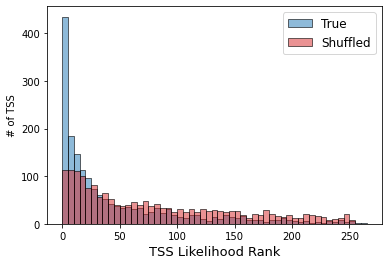

In [167]:
true_sets_ranks = []
shuff_sets_ranks = []
for (_, y_name), tss_prob_ranks in motifs_result_dict.items():
    if y_name == 'true':
        true_sets_ranks.extend(tss_prob_ranks)
    else:
        shuff_sets_ranks.extend(tss_prob_ranks)

_, ax = plt.subplots()
        
sns.histplot(true_sets_ranks, color='tab:blue', binwidth=5, alpha=0.5, label='True', ax=ax)
sns.histplot(shuff_sets_ranks, color='tab:red', binwidth=5, alpha=0.5, label='Shuffled', ax=ax)
ax.legend(fontsize=12)
ax.set_xlabel('TSS Likelihood Rank', fontsize=13)
ax.set_ylabel('# of TSS')

## Comparison of Feature Sets

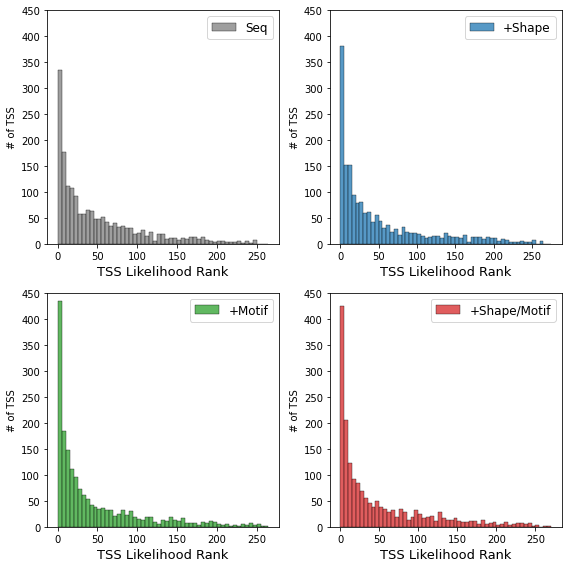

In [180]:
rank_list_dict = {
    'Seq': [],
    '+Shape': [],
    '+Motif': [],
    '+Shape/Motif': []
}
for (_, y_name), tss_prob_ranks in trial_result_dict.items():
    if y_name == 'true':
        rank_list_dict['Seq'].extend(tss_prob_ranks)
        
for (_, y_name), tss_prob_ranks in with_shape_result_dict.items():
    if y_name == 'true':
        rank_list_dict['+Shape'].extend(tss_prob_ranks)

for (_, y_name), tss_prob_ranks in motifs_result_dict.items():
    if y_name == 'true':
        rank_list_dict['+Motif'].extend(tss_prob_ranks)

for (_, y_name), tss_prob_ranks in shape_motifs_result_dict.items():
    if y_name == 'true':
        rank_list_dict['+Shape/Motif'].extend(tss_prob_ranks)

_, axs = plt.subplots(2, 2, figsize=(8, 8))
axs = axs.flatten()

cols = ['tab:gray', 'tab:blue', 'tab:green', 'tab:red']
for ax, col, (name, ranks) in zip(axs, cols, rank_list_dict.items()):
    sns.histplot(ranks, color=col, binwidth=5, label=name, ax=ax)
    ax.set_ylim(0, 450)
    ax.legend(fontsize=12)
    ax.set_xlabel('TSS Likelihood Rank', fontsize=13)
    ax.set_ylabel('# of TSS')
    
plt.tight_layout()

## With Label Wiggle

In [328]:
wiggle_result_dict = run_trial(
    n_upstream=250, n_downstream=25, motifs=True, label_wiggle=2,
    n_units=32, activation='tanh',
    n_neurons=(32, 16), dropout_rate=(0.1, 0.1), 
    neg_weight_adjust=1.05,
    batch_size=32, epochs=50, patience=10
)

Epoch 1/50
38/38 [==============================] - 4s 117ms/step - loss: 0.6846 - accuracy: 0.6311 - auroc: 0.5719 - auprc: 0.0275 - fn: 3950.0000 - fp: 117817.0000 - tn: 205016.0000 - tp: 3313.0000 - val_loss: 0.6320 - val_accuracy: 0.5982 - val_auroc: 0.6357 - val_auprc: 0.0062 - val_fn: 145.0000 - val_fp: 33013.0000 - val_tn: 49157.0000 - val_tp: 209.0000
Epoch 2/50
38/38 [==============================] - 4s 94ms/step - loss: 0.6491 - accuracy: 0.5712 - auroc: 0.6657 - auprc: 0.0376 - fn: 2330.0000 - fp: 139211.0000 - tn: 183622.0000 - tp: 4933.0000 - val_loss: 0.5776 - val_accuracy: 0.6176 - val_auroc: 0.6766 - val_auprc: 0.0070 - val_fn: 126.0000 - val_fp: 31430.0000 - val_tn: 50740.0000 - val_tp: 228.0000
Epoch 3/50
38/38 [==============================] - 4s 95ms/step - loss: 0.6271 - accuracy: 0.5873 - auroc: 0.7015 - auprc: 0.0465 - fn: 2048.0000 - fp: 134191.0000 - tn: 188642.0000 - tp: 5215.0000 - val_loss: 0.5815 - val_accuracy: 0.6392 - val_auroc: 0.7188 - val_auprc: 0.0

Epoch 24/50
38/38 [==============================] - 5s 124ms/step - loss: 0.4090 - accuracy: 0.8087 - auroc: 0.8941 - auprc: 0.2111 - fn: 1341.0000 - fp: 61808.0000 - tn: 261025.0000 - tp: 5922.0000 - val_loss: 0.3661 - val_accuracy: 0.8186 - val_auroc: 0.8463 - val_auprc: 0.0365 - val_fn: 106.0000 - val_fp: 14865.0000 - val_tn: 67305.0000 - val_tp: 248.0000
Epoch 25/50
38/38 [==============================] - 4s 110ms/step - loss: 0.3967 - accuracy: 0.8083 - auroc: 0.9001 - auprc: 0.2118 - fn: 1227.0000 - fp: 62067.0000 - tn: 260766.0000 - tp: 6036.0000 - val_loss: 0.3996 - val_accuracy: 0.8009 - val_auroc: 0.8481 - val_auprc: 0.0368 - val_fn: 91.0000 - val_fp: 16343.0000 - val_tn: 65827.0000 - val_tp: 263.0000
Epoch 26/50
38/38 [==============================] - 4s 98ms/step - loss: 0.3901 - accuracy: 0.8079 - auroc: 0.9033 - auprc: 0.2195 - fn: 1180.0000 - fp: 62223.0000 - tn: 260610.0000 - tp: 6083.0000 - val_loss: 0.4155 - val_accuracy: 0.7867 - val_auroc: 0.8414 - val_auprc: 0.0

Epoch 15/50
38/38 [==============================] - 4s 103ms/step - loss: 0.5732 - accuracy: 0.7391 - auroc: 0.7674 - auprc: 0.0686 - fn: 2509.0000 - fp: 83617.0000 - tn: 239216.0000 - tp: 4754.0000 - val_loss: 0.5451 - val_accuracy: 0.7531 - val_auroc: 0.7346 - val_auprc: 0.0147 - val_fn: 143.0000 - val_fp: 20230.0000 - val_tn: 61940.0000 - val_tp: 211.0000
Epoch 16/50
38/38 [==============================] - 4s 101ms/step - loss: 0.5682 - accuracy: 0.7348 - auroc: 0.7704 - auprc: 0.0696 - fn: 2376.0000 - fp: 85158.0000 - tn: 237675.0000 - tp: 4887.0000 - val_loss: 0.5416 - val_accuracy: 0.7164 - val_auroc: 0.7463 - val_auprc: 0.0147 - val_fn: 126.0000 - val_fp: 23281.0000 - val_tn: 58889.0000 - val_tp: 228.0000
Epoch 17/50
38/38 [==============================] - 4s 102ms/step - loss: 0.5649 - accuracy: 0.7113 - auroc: 0.7739 - auprc: 0.0692 - fn: 2145.0000 - fp: 93152.0000 - tn: 229681.0000 - tp: 5118.0000 - val_loss: 0.5810 - val_accuracy: 0.7096 - val_auroc: 0.7422 - val_auprc: 0

Epoch 21/50
38/38 [==============================] - 4s 96ms/step - loss: 0.4059 - accuracy: 0.8014 - auroc: 0.8952 - auprc: 0.2094 - fn: 1273.0000 - fp: 64275.0000 - tn: 258522.0000 - tp: 6026.0000 - val_loss: 0.3198 - val_accuracy: 0.8471 - val_auroc: 0.8470 - val_auprc: 0.0408 - val_fn: 115.0000 - val_fp: 12505.0000 - val_tn: 69672.0000 - val_tp: 232.0000
Epoch 22/50
38/38 [==============================] - 4s 98ms/step - loss: 0.4074 - accuracy: 0.7998 - auroc: 0.8945 - auprc: 0.2035 - fn: 1271.0000 - fp: 64828.0000 - tn: 257969.0000 - tp: 6028.0000 - val_loss: 0.4320 - val_accuracy: 0.7762 - val_auroc: 0.8518 - val_auprc: 0.0420 - val_fn: 83.0000 - val_fp: 18384.0000 - val_tn: 63793.0000 - val_tp: 264.0000
Epoch 23/50
38/38 [==============================] - 4s 95ms/step - loss: 0.3998 - accuracy: 0.8004 - auroc: 0.8984 - auprc: 0.2113 - fn: 1176.0000 - fp: 64723.0000 - tn: 258074.0000 - tp: 6123.0000 - val_loss: 0.4457 - val_accuracy: 0.7674 - val_auroc: 0.8498 - val_auprc: 0.041

Epoch 13/50
38/38 [==============================] - 4s 93ms/step - loss: 0.5672 - accuracy: 0.7322 - auroc: 0.7717 - auprc: 0.0719 - fn: 2442.0000 - fp: 85956.0000 - tn: 236841.0000 - tp: 4857.0000 - val_loss: 0.5565 - val_accuracy: 0.7243 - val_auroc: 0.7409 - val_auprc: 0.0126 - val_fn: 122.0000 - val_fp: 22632.0000 - val_tn: 59545.0000 - val_tp: 225.0000
Epoch 14/50
38/38 [==============================] - 3s 92ms/step - loss: 0.5638 - accuracy: 0.7265 - auroc: 0.7751 - auprc: 0.0720 - fn: 2301.0000 - fp: 87970.0000 - tn: 234827.0000 - tp: 4998.0000 - val_loss: 0.5107 - val_accuracy: 0.7643 - val_auroc: 0.7426 - val_auprc: 0.0124 - val_fn: 139.0000 - val_fp: 19314.0000 - val_tn: 62863.0000 - val_tp: 208.0000
Epoch 15/50
38/38 [==============================] - 4s 92ms/step - loss: 0.5622 - accuracy: 0.7225 - auroc: 0.7768 - auprc: 0.0736 - fn: 2317.0000 - fp: 89298.0000 - tn: 233499.0000 - tp: 4982.0000 - val_loss: 0.5702 - val_accuracy: 0.6847 - val_auroc: 0.7459 - val_auprc: 0.01

Epoch 36/50
38/38 [==============================] - 4s 92ms/step - loss: 0.5007 - accuracy: 0.7039 - auroc: 0.8251 - auprc: 0.0884 - fn: 1515.0000 - fp: 96223.0000 - tn: 226574.0000 - tp: 5784.0000 - val_loss: 0.4923 - val_accuracy: 0.7028 - val_auroc: 0.7296 - val_auprc: 0.0116 - val_fn: 125.0000 - val_fp: 24402.0000 - val_tn: 57775.0000 - val_tp: 222.0000
Epoch 1/50
38/38 [==============================] - 4s 114ms/step - loss: 0.6774 - accuracy: 0.7050 - auroc: 0.5978 - auprc: 0.0303 - fn: 4275.0000 - fp: 93088.0000 - tn: 229820.0000 - tp: 2913.0000 - val_loss: 0.6238 - val_accuracy: 0.5792 - val_auroc: 0.6417 - val_auprc: 0.0072 - val_fn: 131.0000 - val_fp: 34592.0000 - val_tn: 47563.0000 - val_tp: 238.0000
Epoch 2/50
38/38 [==============================] - 3s 87ms/step - loss: 0.6437 - accuracy: 0.5649 - auroc: 0.6719 - auprc: 0.0378 - fn: 2163.0000 - fp: 141473.0000 - tn: 181435.0000 - tp: 5025.0000 - val_loss: 0.5497 - val_accuracy: 0.6237 - val_auroc: 0.6804 - val_auprc: 0.00

Epoch 23/50
38/38 [==============================] - 4s 95ms/step - loss: 0.4075 - accuracy: 0.8064 - auroc: 0.8949 - auprc: 0.2066 - fn: 1285.0000 - fp: 62608.0000 - tn: 260300.0000 - tp: 5903.0000 - val_loss: 0.3389 - val_accuracy: 0.8435 - val_auroc: 0.8507 - val_auprc: 0.0455 - val_fn: 128.0000 - val_fp: 12783.0000 - val_tn: 69372.0000 - val_tp: 241.0000
Epoch 24/50
38/38 [==============================] - 4s 95ms/step - loss: 0.4025 - accuracy: 0.8151 - auroc: 0.8976 - auprc: 0.2155 - fn: 1293.0000 - fp: 59754.0000 - tn: 263154.0000 - tp: 5895.0000 - val_loss: 0.4470 - val_accuracy: 0.7797 - val_auroc: 0.8582 - val_auprc: 0.0505 - val_fn: 85.0000 - val_fp: 18091.0000 - val_tn: 64064.0000 - val_tp: 284.0000
Epoch 25/50
38/38 [==============================] - 3s 92ms/step - loss: 0.3955 - accuracy: 0.8091 - auroc: 0.9010 - auprc: 0.2129 - fn: 1182.0000 - fp: 61836.0000 - tn: 261072.0000 - tp: 6006.0000 - val_loss: 0.4402 - val_accuracy: 0.7762 - val_auroc: 0.8546 - val_auprc: 0.051

Epoch 13/50
38/38 [==============================] - 4s 98ms/step - loss: 0.5724 - accuracy: 0.7443 - auroc: 0.7665 - auprc: 0.0661 - fn: 2576.0000 - fp: 81840.0000 - tn: 241068.0000 - tp: 4612.0000 - val_loss: 0.5523 - val_accuracy: 0.7389 - val_auroc: 0.7300 - val_auprc: 0.0132 - val_fn: 159.0000 - val_fp: 21391.0000 - val_tn: 60764.0000 - val_tp: 210.0000
Epoch 14/50
38/38 [==============================] - 4s 93ms/step - loss: 0.5725 - accuracy: 0.7375 - auroc: 0.7656 - auprc: 0.0672 - fn: 2548.0000 - fp: 84099.0000 - tn: 238809.0000 - tp: 4640.0000 - val_loss: 0.5883 - val_accuracy: 0.6938 - val_auroc: 0.7387 - val_auprc: 0.0134 - val_fn: 131.0000 - val_fp: 25141.0000 - val_tn: 57014.0000 - val_tp: 238.0000
Epoch 15/50
38/38 [==============================] - 3s 92ms/step - loss: 0.5691 - accuracy: 0.7402 - auroc: 0.7696 - auprc: 0.0678 - fn: 2507.0000 - fp: 83251.0000 - tn: 239657.0000 - tp: 4681.0000 - val_loss: 0.6290 - val_accuracy: 0.6846 - val_auroc: 0.7382 - val_auprc: 0.01

Epoch 17/50
38/38 [==============================] - 3s 88ms/step - loss: 0.4271 - accuracy: 0.7959 - auroc: 0.8838 - auprc: 0.1785 - fn: 1326.0000 - fp: 66050.0000 - tn: 256815.0000 - tp: 5905.0000 - val_loss: 0.4070 - val_accuracy: 0.7987 - val_auroc: 0.8420 - val_auprc: 0.0410 - val_fn: 99.0000 - val_fp: 16517.0000 - val_tn: 65646.0000 - val_tp: 262.0000
Epoch 18/50
38/38 [==============================] - 3s 87ms/step - loss: 0.4157 - accuracy: 0.7959 - auroc: 0.8895 - auprc: 0.1879 - fn: 1291.0000 - fp: 66070.0000 - tn: 256795.0000 - tp: 5940.0000 - val_loss: 0.3870 - val_accuracy: 0.8030 - val_auroc: 0.8421 - val_auprc: 0.0427 - val_fn: 101.0000 - val_fp: 16159.0000 - val_tn: 66004.0000 - val_tp: 260.0000
Epoch 19/50
38/38 [==============================] - 3s 87ms/step - loss: 0.4119 - accuracy: 0.7940 - auroc: 0.8912 - auprc: 0.1901 - fn: 1232.0000 - fp: 66770.0000 - tn: 256095.0000 - tp: 5999.0000 - val_loss: 0.4049 - val_accuracy: 0.7948 - val_auroc: 0.8422 - val_auprc: 0.041

Epoch 6/50
38/38 [==============================] - 3s 89ms/step - loss: 0.6283 - accuracy: 0.5041 - auroc: 0.6832 - auprc: 0.0394 - fn: 1601.0000 - fp: 162104.0000 - tn: 160761.0000 - tp: 5630.0000 - val_loss: 0.6834 - val_accuracy: 0.4343 - val_auroc: 0.7264 - val_auprc: 0.0118 - val_fn: 54.0000 - val_fp: 46633.0000 - val_tn: 35530.0000 - val_tp: 307.0000
Epoch 7/50
38/38 [==============================] - 3s 89ms/step - loss: 0.5912 - accuracy: 0.7078 - auroc: 0.7446 - auprc: 0.0585 - fn: 2523.0000 - fp: 93940.0000 - tn: 228925.0000 - tp: 4708.0000 - val_loss: 0.5792 - val_accuracy: 0.7474 - val_auroc: 0.7473 - val_auprc: 0.0123 - val_fn: 145.0000 - val_fp: 20700.0000 - val_tn: 61463.0000 - val_tp: 216.0000
Epoch 8/50
38/38 [==============================] - 3s 90ms/step - loss: 0.5877 - accuracy: 0.7545 - auroc: 0.7488 - auprc: 0.0584 - fn: 2841.0000 - fp: 78183.0000 - tn: 244682.0000 - tp: 4390.0000 - val_loss: 0.5565 - val_accuracy: 0.7235 - val_auroc: 0.7518 - val_auprc: 0.0130 

Epoch 29/50
38/38 [==============================] - 3s 88ms/step - loss: 0.5336 - accuracy: 0.7064 - auroc: 0.8007 - auprc: 0.0751 - fn: 1822.0000 - fp: 95098.0000 - tn: 227767.0000 - tp: 5409.0000 - val_loss: 0.5186 - val_accuracy: 0.7107 - val_auroc: 0.7440 - val_auprc: 0.0132 - val_fn: 137.0000 - val_fp: 23734.0000 - val_tn: 58429.0000 - val_tp: 224.0000
Epoch 30/50
38/38 [==============================] - 3s 90ms/step - loss: 0.5309 - accuracy: 0.7148 - auroc: 0.8017 - auprc: 0.0754 - fn: 1869.0000 - fp: 92290.0000 - tn: 230575.0000 - tp: 5362.0000 - val_loss: 0.5396 - val_accuracy: 0.6926 - val_auroc: 0.7462 - val_auprc: 0.0136 - val_fn: 135.0000 - val_fp: 25232.0000 - val_tn: 56931.0000 - val_tp: 226.0000
Epoch 31/50
38/38 [==============================] - 3s 89ms/step - loss: 0.5296 - accuracy: 0.6921 - auroc: 0.8031 - auprc: 0.0769 - fn: 1707.0000 - fp: 99929.0000 - tn: 222936.0000 - tp: 5524.0000 - val_loss: 0.5399 - val_accuracy: 0.6987 - val_auroc: 0.7322 - val_auprc: 0.01

Epoch 2/50
38/38 [==============================] - 3s 87ms/step - loss: 0.6419 - accuracy: 0.5627 - auroc: 0.6719 - auprc: 0.0388 - fn: 2176.0000 - fp: 142180.0000 - tn: 180777.0000 - tp: 4963.0000 - val_loss: 0.6560 - val_accuracy: 0.4761 - val_auroc: 0.6900 - val_auprc: 0.0090 - val_fn: 69.0000 - val_fp: 43169.0000 - val_tn: 38976.0000 - val_tp: 310.0000
Epoch 3/50
38/38 [==============================] - 3s 89ms/step - loss: 0.6177 - accuracy: 0.6050 - auroc: 0.7109 - auprc: 0.0482 - fn: 2090.0000 - fp: 128287.0000 - tn: 194670.0000 - tp: 5049.0000 - val_loss: 0.5655 - val_accuracy: 0.6073 - val_auroc: 0.7144 - val_auprc: 0.0109 - val_fn: 118.0000 - val_fp: 32293.0000 - val_tn: 49852.0000 - val_tp: 261.0000
Epoch 4/50
38/38 [==============================] - 3s 91ms/step - loss: 0.5917 - accuracy: 0.6327 - auroc: 0.7446 - auprc: 0.0588 - fn: 1915.0000 - fp: 119345.0000 - tn: 203612.0000 - tp: 5224.0000 - val_loss: 0.4721 - val_accuracy: 0.7213 - val_auroc: 0.7439 - val_auprc: 0.013

Epoch 25/50
38/38 [==============================] - 3s 89ms/step - loss: 0.3845 - accuracy: 0.8138 - auroc: 0.9063 - auprc: 0.2039 - fn: 1067.0000 - fp: 60384.0000 - tn: 262573.0000 - tp: 6072.0000 - val_loss: 0.4301 - val_accuracy: 0.7847 - val_auroc: 0.8412 - val_auprc: 0.0408 - val_fn: 105.0000 - val_fp: 17662.0000 - val_tn: 64483.0000 - val_tp: 274.0000
Epoch 26/50
38/38 [==============================] - 3s 89ms/step - loss: 0.3736 - accuracy: 0.8243 - auroc: 0.9115 - auprc: 0.2124 - fn: 1025.0000 - fp: 56975.0000 - tn: 265982.0000 - tp: 6114.0000 - val_loss: 0.3386 - val_accuracy: 0.8371 - val_auroc: 0.8324 - val_auprc: 0.0421 - val_fn: 130.0000 - val_fp: 13316.0000 - val_tn: 68829.0000 - val_tp: 249.0000
Epoch 27/50
38/38 [==============================] - 4s 100ms/step - loss: 0.3718 - accuracy: 0.8231 - auroc: 0.9120 - auprc: 0.2156 - fn: 1049.0000 - fp: 57346.0000 - tn: 265611.0000 - tp: 6090.0000 - val_loss: 0.4279 - val_accuracy: 0.7816 - val_auroc: 0.8365 - val_auprc: 0.0

Epoch 19/50
38/38 [==============================] - 4s 98ms/step - loss: 0.5555 - accuracy: 0.6874 - auroc: 0.7816 - auprc: 0.0693 - fn: 1954.0000 - fp: 101229.0000 - tn: 221728.0000 - tp: 5185.0000 - val_loss: 0.4938 - val_accuracy: 0.7844 - val_auroc: 0.7597 - val_auprc: 0.0144 - val_fn: 158.0000 - val_fp: 17631.0000 - val_tn: 64514.0000 - val_tp: 221.0000
Epoch 20/50
38/38 [==============================] - 4s 98ms/step - loss: 0.5544 - accuracy: 0.7088 - auroc: 0.7825 - auprc: 0.0722 - fn: 2104.0000 - fp: 94015.0000 - tn: 228942.0000 - tp: 5035.0000 - val_loss: 0.5278 - val_accuracy: 0.7023 - val_auroc: 0.7630 - val_auprc: 0.0146 - val_fn: 124.0000 - val_fp: 24442.0000 - val_tn: 57703.0000 - val_tp: 255.0000
Epoch 21/50
38/38 [==============================] - 4s 94ms/step - loss: 0.5501 - accuracy: 0.7074 - auroc: 0.7859 - auprc: 0.0695 - fn: 2021.0000 - fp: 94574.0000 - tn: 228383.0000 - tp: 5118.0000 - val_loss: 0.5589 - val_accuracy: 0.7012 - val_auroc: 0.7687 - val_auprc: 0.0

Epoch 42/50
38/38 [==============================] - 3s 89ms/step - loss: 0.4974 - accuracy: 0.7039 - auroc: 0.8254 - auprc: 0.0820 - fn: 1442.0000 - fp: 96308.0000 - tn: 226649.0000 - tp: 5697.0000 - val_loss: 0.5517 - val_accuracy: 0.6373 - val_auroc: 0.7358 - val_auprc: 0.0120 - val_fn: 112.0000 - val_fp: 29820.0000 - val_tn: 52325.0000 - val_tp: 267.0000
Epoch 43/50
38/38 [==============================] - 3s 90ms/step - loss: 0.5020 - accuracy: 0.6773 - auroc: 0.8222 - auprc: 0.0810 - fn: 1312.0000 - fp: 105218.0000 - tn: 217739.0000 - tp: 5827.0000 - val_loss: 0.5267 - val_accuracy: 0.6718 - val_auroc: 0.7214 - val_auprc: 0.0114 - val_fn: 131.0000 - val_fp: 26957.0000 - val_tn: 55188.0000 - val_tp: 248.0000
Epoch 44/50
38/38 [==============================] - 4s 94ms/step - loss: 0.5120 - accuracy: 0.6795 - auroc: 0.8136 - auprc: 0.0767 - fn: 1415.0000 - fp: 104384.0000 - tn: 218573.0000 - tp: 5724.0000 - val_loss: 0.3965 - val_accuracy: 0.7899 - val_auroc: 0.7289 - val_auprc: 0.

Text(0, 0.5, '# of TSS')

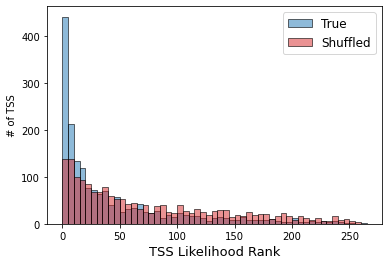

In [329]:
true_sets_ranks = []
shuff_sets_ranks = []
for (_, y_name), tss_prob_ranks in wiggle_result_dict.items():
    if y_name == 'true':
        true_sets_ranks.extend(tss_prob_ranks)
    else:
        shuff_sets_ranks.extend(tss_prob_ranks)

_, ax = plt.subplots()
        
sns.histplot(true_sets_ranks, color='tab:blue', binwidth=5, alpha=0.5, label='True', ax=ax)
sns.histplot(shuff_sets_ranks, color='tab:red', binwidth=5, alpha=0.5, label='Shuffled', ax=ax)
ax.legend(fontsize=12)
ax.set_xlabel('TSS Likelihood Rank', fontsize=13)
ax.set_ylabel('# of TSS')